In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
loan_data = pd.read_pickle("../loan_data_defaultDefinition.pkl")
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,addr_state: UT,addr_state: VA,addr_state: VT,addr_state: WA,addr_state: WI,addr_state: WV,addr_state: WY,initial_list_status: f,initial_list_status: w,good_bad
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,False,False,False,False,False,False,False,True,False,1
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,False,False,False,False,False,False,False,True,False,0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,False,False,False,False,False,False,False,True,False,1
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,False,False,False,False,False,False,False,True,False,1
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,False,False,False,False,False,False,False,True,False,1


 ### Splitting dataset into test and training respectively 
 - We split two dataframes with inputs and targets, each into a train and test dataframe, and store them in variables
 - Takes a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
 - Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.
 - We set the size of the test dataset to be 20%.
 - Respectively, the size of the train dataset becomes 80%.
 - We also set a specific random state for reproducibility just as setting seed.
 - This would allow us to perform the exact same split multimple times.
 - This means, to assign the exact same observations to the train and test datasets.

In [3]:
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(loan_data.drop('good_bad', axis = 1), loan_data['good_bad'],test_size = 0.2, random_state = 42)

In [4]:
print("The following is the output for the shape of dataframe (rows,columns) \n")

print(f"Training dataset with explanatory variables : {loan_data_inputs_train.shape} \n")
# Displays the size of the dataframe.
print(f"Training dataset with target variable : {loan_data_targets_train.shape} \n")
# Displays the size of the dataframe.
print(f"Testing dataset with explanatory variables : {loan_data_inputs_test.shape} \n")
# Displays the size of the dataframe.
print(f"Testing dataset with target variable :{loan_data_targets_test.shape} \n")
# Displays the size of the dataframe.

The following is the output for the shape of dataframe (rows,columns) 

Training dataset with explanatory variables : (373028, 205) 

Training dataset with target variable : (373028,) 

Testing dataset with explanatory variables : (93257, 205) 

Testing dataset with target variable :(93257,) 



# Feature Engineering

### Creating function for weight of evidence encoding

In [5]:
# WoE function for discrete unordered variables
def woe_discrete(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we combine all of the operations above in a function.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

### Creating function for visualizing results

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# Imports the libraries we need.
sns.set()
# We set the default style of the graphs to the seaborn style. 

# Below we define a function that takes 2 arguments: a dataframe and a number.
# The number parameter has a default value of 0.
# This means that if we call the function and omit the number parameter, it will be executed with it having a value of 0.
# The function displays a graph.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    # Turns the values of the column with index 0 to strings, makes an array from these strings, and passes it to variable x.
    y = df_WoE['WoE']
    # Selects a column with label 'WoE' and passes it to variable y.
    plt.figure(figsize=(18, 6))
    # Sets the graph size to width 18 x height 6.
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    # Plots the datapoints with coordiantes variable x on the x-axis and variable y on the y-axis.
    # Sets the marker for each datapoint to a circle, the style line between the points to dashed, and the color to black.
    plt.xlabel(df_WoE.columns[0])
    # Names the x-axis with the name of the column with index 0.
    plt.ylabel('Weight of Evidence')
    # Names the y-axis 'Weight of Evidence'.
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    # Names the grapth 'Weight of Evidence by ' the name of the column with index 0.
    plt.xticks(rotation = rotation_of_x_axis_labels)
    # Rotates the labels of the x-axis a predefined number of degrees.

### Copy datasets for preprocessing

In [7]:
df_inputs_prepr = loan_data_inputs_train
df_targets_prepr = loan_data_targets_train

## 1. Preprocessing Discrete Variables : Creating Dummy Variables

### 1. Variable : Grade

In [8]:
df_temp = woe_discrete(df_inputs_prepr, 'grade', df_targets_prepr)
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,NaN,NaN,0.288636
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.026458,0.138019,0.288636
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.050841,0.297173,0.288636
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.041047,0.286424,0.288636
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.039466,0.342340,0.288636
5,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476,0.035245,0.407979,0.288636
6,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830,0.040028,0.749353,0.288636


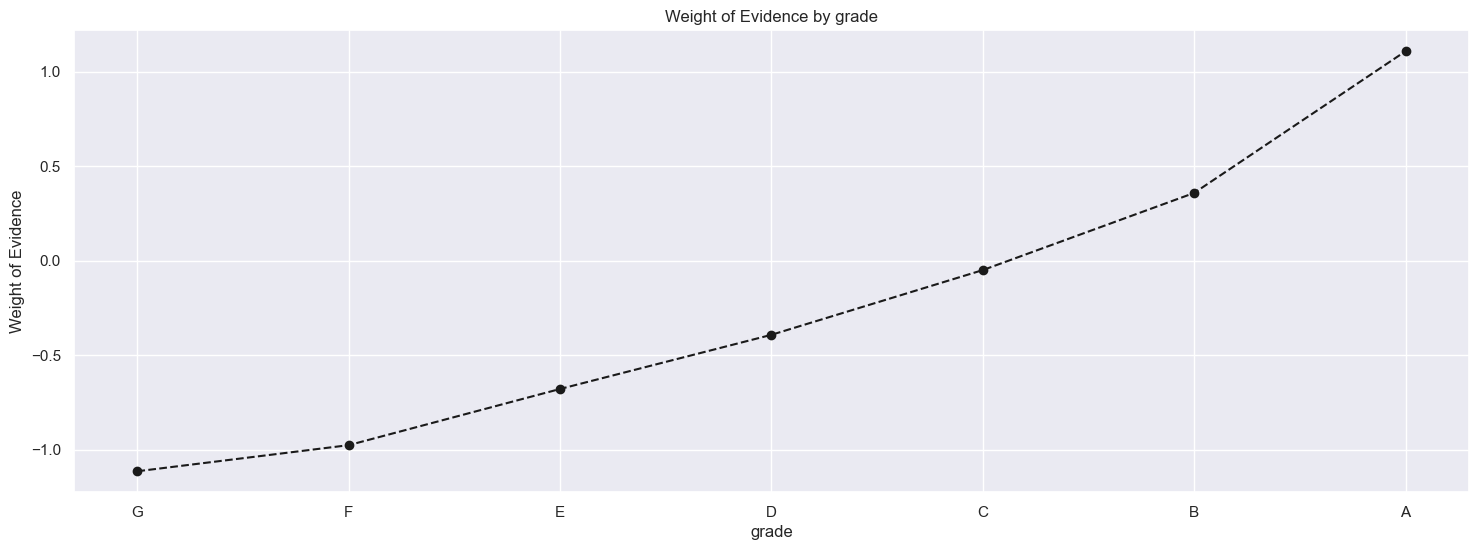

In [9]:
plot_by_woe(df_temp)

We take the worst category as a Reference category. 

- Hence, here for variable **GRADE** we will keep **G** as reference category. 

By using a reference category, the WoE values of the other categories are calculated relative to that reference point.It serves as a benchmark against which the other categories are compared, allowing for a meaningful comparison of the predictive power of different categories.

it's essential to carefully select the reference category based on the domain knowledge and the specific objectives of the analysis.

- Its a good practice to keep a track of reference category when we create dummy variable for each original variable

### 2. Variable: home_ownership

In [10]:
df_temp = woe_discrete(df_inputs_prepr, 'home_ownership', df_targets_prepr)
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,137,0.795620,0.000367,109.0,28.0,0.000328,0.000687,-0.738602,NaN,NaN,inf
1,NONE,40,0.850000,0.000107,34.0,6.0,0.000102,0.000147,-0.363144,0.054380,0.375458,inf
2,RENT,150599,0.873870,0.403720,131604.0,18995.0,0.396099,0.465815,-0.162123,0.023870,0.201021,inf
3,OWN,33295,0.892536,0.089256,29717.0,3578.0,0.089442,0.087743,0.019170,0.018666,0.181294,inf
4,MORTGAGE,188956,0.903835,0.506546,170785.0,18171.0,0.514026,0.445608,0.142834,0.011298,0.123663,inf
5,ANY,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.096165,inf,inf


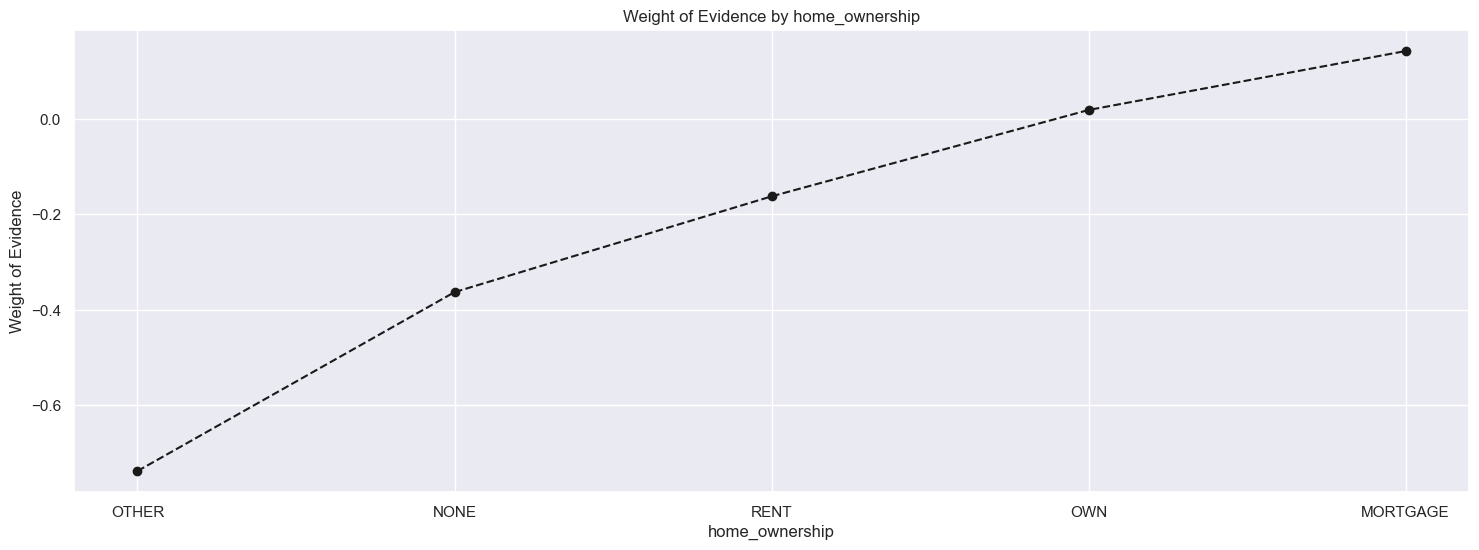

In [11]:
plot_by_woe(df_temp)

In [12]:
# There are many categories with very few observations and many categories with very different "good" %.
# Therefore, we create a new discrete variable where we combine some of the categories.
# 'OTHERS' and 'NONE' are riskiest but are very few. 'RENT' is the next riskiest.
# 'ANY' are least risky but are too few. Conceptually, they belong to the same category. Also, their inclusion would not change anything.
# We combine them in one category, 'RENT_OTHER_NONE_ANY'.
# We end up with 3 categories: 'RENT_OTHER_NONE_ANY', 'OWN', 'MORTGAGE'.
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership: RENT'], df_inputs_prepr['home_ownership: OTHER'],
                                                      df_inputs_prepr['home_ownership: NONE'],df_inputs_prepr['home_ownership: ANY']])

**'RENT_OTHER_NONE_ANY' will be the reference category.**

### 3. Variable: addr_state

In [13]:
df_inputs_prepr['addr_state'].unique()

array(['SC', 'NJ', 'GA', 'MA', 'CA', 'IL', 'NC', 'NY', 'TX', 'CT', 'FL',
       'VA', 'UT', 'AZ', 'MD', 'WI', 'MI', 'CO', 'TN', 'IN', 'AL', 'NV',
       'MT', 'RI', 'OR', 'MN', 'KS', 'AK', 'PA', 'OH', 'WA', 'KY', 'OK',
       'MO', 'NM', 'HI', 'WV', 'LA', 'VT', 'AR', 'DC', 'SD', 'NH', 'WY',
       'MS', 'DE', 'IA', 'NE', 'ID', 'ME'], dtype=object)

North Dakota [ND] is missing from the addr_state list so we will add it 

In [14]:
if ['addr_state: ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state: ND'] = 0

In [15]:
df_temp = woe_discrete(df_inputs_prepr, 'addr_state', df_targets_prepr)
# We calculate weight of evidence.

df_temp.sort_values(by='n_obs', ascending=False)

,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
15,CA,57199,0.885645,0.153337,50658.0,6541.0,0.152470,0.160405,-0.050738,0.000012,0.000116,inf
8,NY,32211,0.883984,0.086350,28474.0,3737.0,0.085701,0.091643,-0.067037,0.000120,0.001165,inf
35,TX,29158,0.903800,0.078166,26353.0,2805.0,0.079317,0.068787,0.142434,0.002621,0.029789,inf
3,FL,25211,0.875808,0.067585,22080.0,3131.0,0.066456,0.076782,-0.144425,0.011223,0.099411,inf
36,IL,14833,0.904874,0.039764,13422.0,1411.0,0.040397,0.034602,0.154852,0.001074,0.012418,inf
19,NJ,14385,0.888286,0.038563,12778.0,1607.0,0.038459,0.039409,-0.024389,0.000027,0.000275,inf
22,PA,13090,0.890451,0.035091,11656.0,1434.0,0.035082,0.035166,-0.002392,0.000014,0.000148,inf
23,OH,12135,0.890894,0.032531,10811.0,1324.0,0.032539,0.032468,0.002162,0.000443,0.004553,inf
30,GA,11960,0.896990,0.032062,10728.0,1232.0,0.032289,0.030212,0.066473,0.002940,0.031425,inf
7,VA,11366,0.883864,0.030470,10046.0,1320.0,0.030236,0.032370,-0.068202,0.000491,0.004771,inf


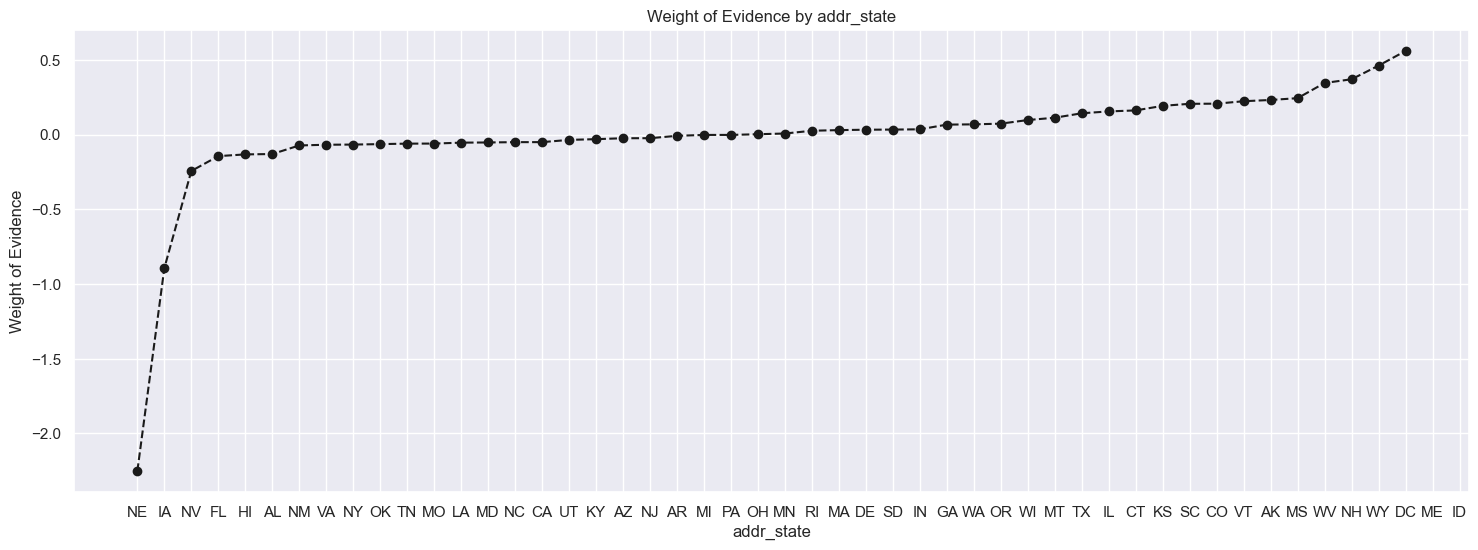

In [16]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

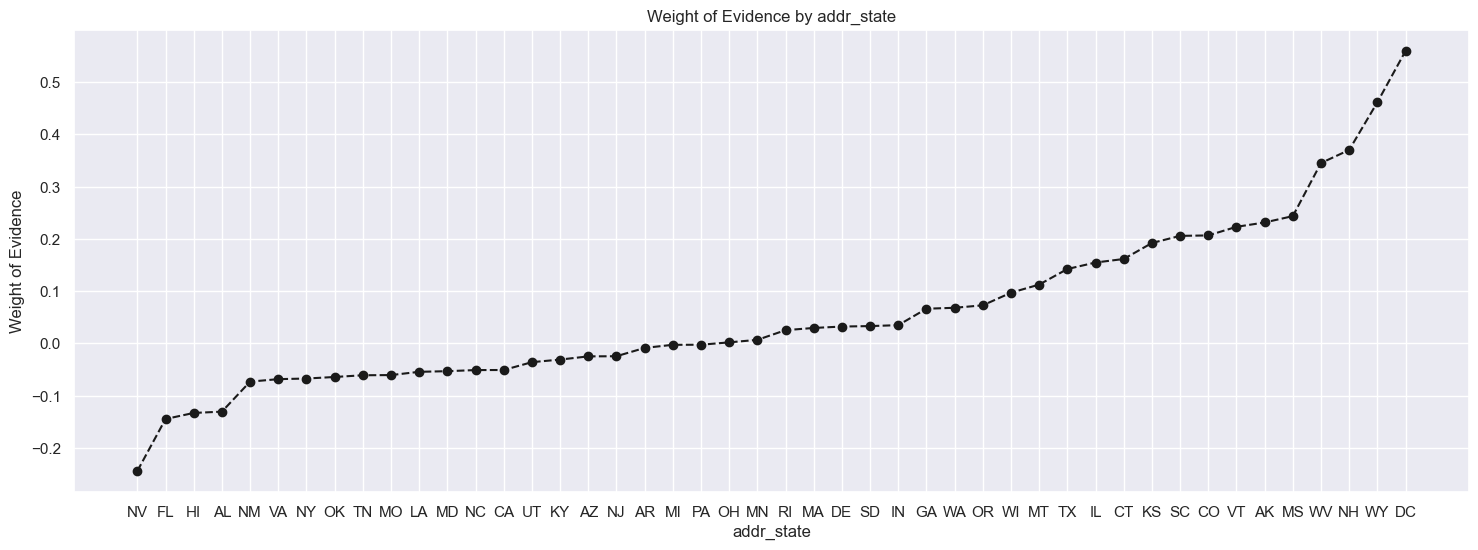

In [17]:
plot_by_woe(df_temp.iloc[2: -2, : ])

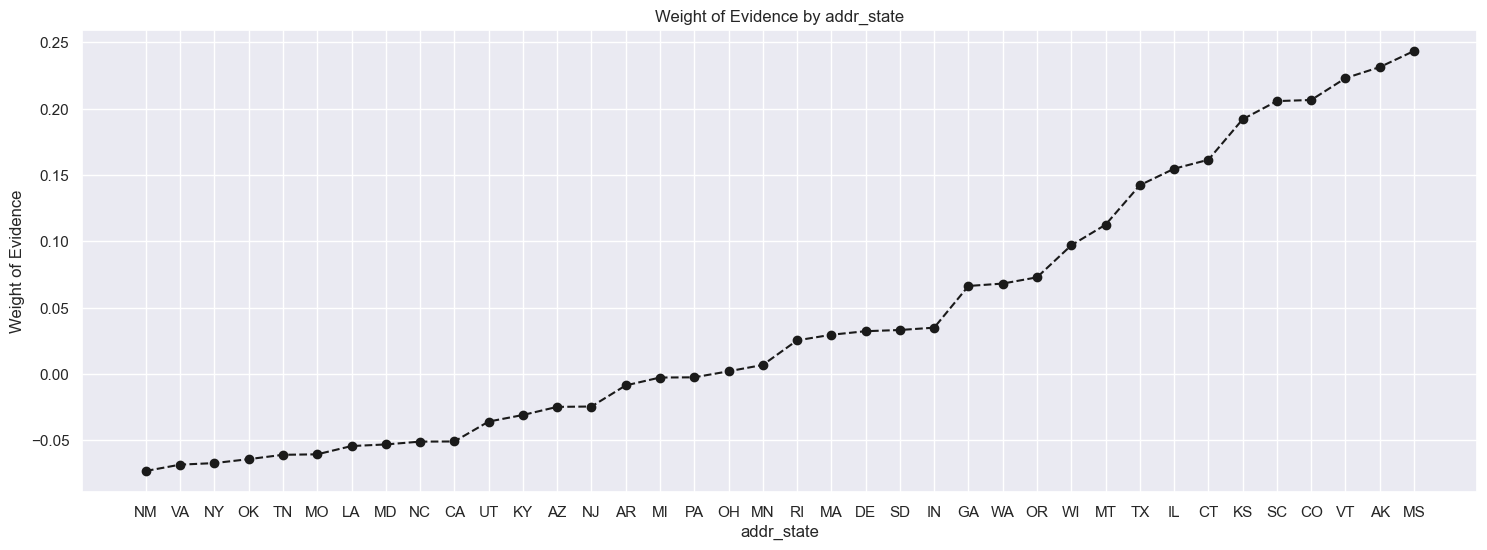

In [18]:
plot_by_woe(df_temp.iloc[6: -6, : ])
# We plot the weight of evidence values.

In [19]:
# We create the following categories:
# 'ND' 'NE' 'IA' NV' 'FL' 'HI' 'AL'
# 'NM' 'VA'
# 'NY'
# 'OK' 'TN' 'MO' 'LA' 'MD' 'NC'
# 'CA'
# 'UT' 'KY' 'AZ' 'NJ'
# 'AR' 'MI' 'PA' 'OH' 'MN'
# 'RI' 'MA' 'DE' 'SD' 'IN'
# 'GA' 'WA' 'OR'
# 'WI' 'MT'
# 'TX'
# 'IL' 'CT'
# 'KS' 'SC' 'CO' 'VT' 'AK' 'MS'
# 'WV' 'NH' 'WY' 'DC' 'ME' 'ID'

# 'IA_NV_HI_ID_AL_FL' will be the reference category.
df_inputs_prepr['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_inputs_prepr['addr_state: ND'], df_inputs_prepr['addr_state: NE'],
                                              df_inputs_prepr['addr_state: IA'], df_inputs_prepr['addr_state: NV'],
                                              df_inputs_prepr['addr_state: FL'], df_inputs_prepr['addr_state: HI'],
                                                          df_inputs_prepr['addr_state: AL']])

df_inputs_prepr['addr_state:NM_VA'] = sum([df_inputs_prepr['addr_state: NM'], df_inputs_prepr['addr_state: VA']])

df_inputs_prepr['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_inputs_prepr['addr_state: OK'], df_inputs_prepr['addr_state: TN'],
                                              df_inputs_prepr['addr_state: MO'], df_inputs_prepr['addr_state: LA'],
                                              df_inputs_prepr['addr_state: MD'], df_inputs_prepr['addr_state: NC']])

df_inputs_prepr['addr_state:UT_KY_AZ_NJ'] = sum([df_inputs_prepr['addr_state: UT'], df_inputs_prepr['addr_state: KY'],
                                              df_inputs_prepr['addr_state: AZ'], df_inputs_prepr['addr_state: NJ']])

df_inputs_prepr['addr_state:AR_MI_PA_OH_MN'] = sum([df_inputs_prepr['addr_state: AR'], df_inputs_prepr['addr_state: MI'],
                                              df_inputs_prepr['addr_state: PA'], df_inputs_prepr['addr_state: OH'],
                                              df_inputs_prepr['addr_state: MN']])

df_inputs_prepr['addr_state:RI_MA_DE_SD_IN'] = sum([df_inputs_prepr['addr_state: RI'], df_inputs_prepr['addr_state: MA'],
                                              df_inputs_prepr['addr_state: DE'], df_inputs_prepr['addr_state: SD'],
                                              df_inputs_prepr['addr_state: IN']])

df_inputs_prepr['addr_state:GA_WA_OR'] = sum([df_inputs_prepr['addr_state: GA'], df_inputs_prepr['addr_state: WA'],
                                              df_inputs_prepr['addr_state: OR']])

df_inputs_prepr['addr_state:WI_MT'] = sum([df_inputs_prepr['addr_state: WI'], df_inputs_prepr['addr_state: MT']])

df_inputs_prepr['addr_state:IL_CT'] = sum([df_inputs_prepr['addr_state: IL'], df_inputs_prepr['addr_state: CT']])

df_inputs_prepr['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_inputs_prepr['addr_state: KS'], df_inputs_prepr['addr_state: SC'],
                                              df_inputs_prepr['addr_state: CO'], df_inputs_prepr['addr_state: VT'],
                                              df_inputs_prepr['addr_state: AK'], df_inputs_prepr['addr_state: MS']])

df_inputs_prepr['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_inputs_prepr['addr_state: WV'], df_inputs_prepr['addr_state: NH'],
                                              df_inputs_prepr['addr_state: WY'], df_inputs_prepr['addr_state: DC'],
                                              df_inputs_prepr['addr_state: ME'], df_inputs_prepr['addr_state: ID']])

'IA_NV_HI_ID_AL_FL' will be the reference category

### 4. Variable: Verfification Status

In [20]:
df_inputs_prepr['verification_status'].unique()

array(['Source Verified', 'Not Verified', 'Verified'], dtype=object)

In [21]:
# 'verification_status'
df_temp = woe_discrete(df_inputs_prepr, 'verification_status', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,134414,0.872781,0.360332,117314.0,17100.0,0.353090,0.419344,-0.171969,NaN,NaN,0.020384
1,Source Verified,120030,0.895918,0.321772,107537.0,12493.0,0.323663,0.306366,0.054922,0.023137,0.226891,0.020384
2,Not Verified,118584,0.905679,0.317896,107399.0,11185.0,0.323248,0.274290,0.164232,0.009761,0.109311,0.020384


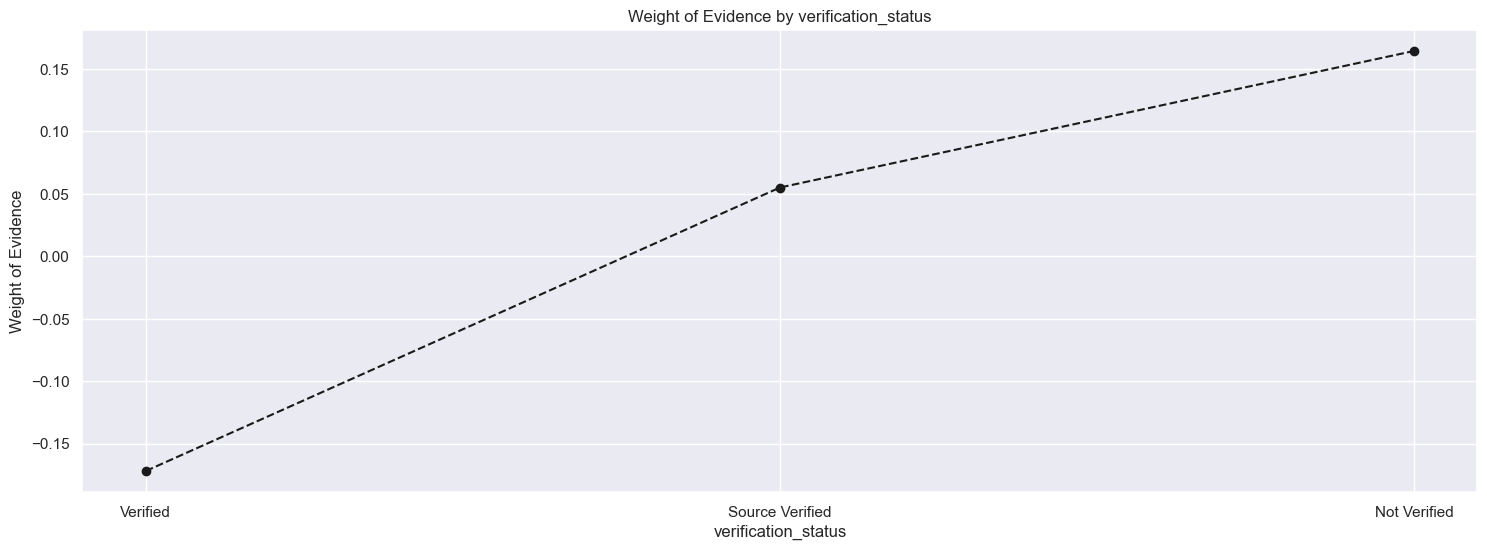

In [22]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

Verified will be the reference category

### 5. Variable: Purpose

In [23]:
df_inputs_prepr['purpose'].unique()

array(['debt_consolidation', 'educational', 'other', 'home_improvement',
       'credit_card', 'major_purchase', 'wedding', 'small_business',
       'vacation', 'house', 'car', 'moving', 'renewable_energy',
       'medical'], dtype=object)

In [24]:
df_temp = woe_discrete(df_inputs_prepr, 'purpose', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,small_business,5582,0.786098,0.014964,4388.0,1194.0,0.013207,0.029280,-0.796180,NaN,NaN,0.035418
1,educational,333,0.801802,0.000893,267.0,66.0,0.000804,0.001619,-0.700151,0.015704,0.096029,0.035418
2,moving,2392,0.839465,0.006412,2008.0,384.0,0.006044,0.009417,-0.443493,0.037663,0.256658,0.035418
3,house,1830,0.860109,0.004906,1574.0,256.0,0.004737,0.006278,-0.281547,0.020644,0.161946,0.035418
4,other,18884,0.862264,0.050624,16283.0,2601.0,0.049008,0.063784,-0.263519,0.002155,0.018028,0.035418
5,renewable_energy,281,0.864769,0.000753,243.0,38.0,0.000731,0.000932,-0.242270,0.002504,0.021250,0.035418
6,medical,3684,0.868350,0.009876,3199.0,485.0,0.009628,0.011894,-0.211300,0.003581,0.030969,0.035418
7,wedding,1887,0.881823,0.005059,1664.0,223.0,0.005008,0.005469,-0.087937,0.013473,0.123363,0.035418
8,vacation,1991,0.882471,0.005337,1757.0,234.0,0.005288,0.005738,-0.081703,0.000648,0.006234,0.035418
9,debt_consolidation,219183,0.886884,0.587578,194390.0,24793.0,0.585071,0.607999,-0.038440,0.004413,0.043263,0.035418


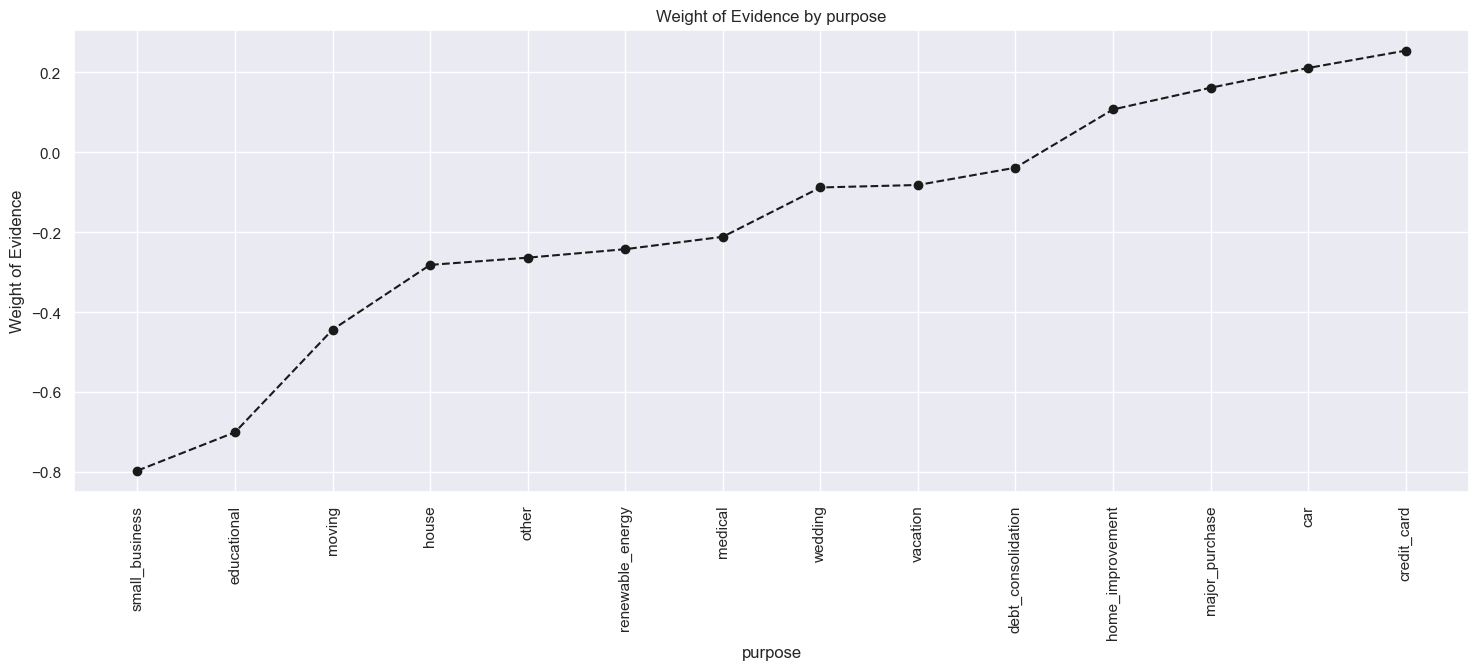

In [25]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [26]:
# We combine 'educational', 'small_business', 'wedding', 'renewable_energy', 'moving', 'house' in one category: 'educ__sm_b__wedd__ren_en__mov__house'.
# We combine 'other', 'medical', 'vacation' in one category: 'oth__med__vacation'.
# We combine 'major_purchase', 'car', 'home_improvement' in one category: 'major_purch__car__home_impr'.
# We leave 'debt_consolidtion' in a separate category.
# We leave 'credit_card' in a separate category.
# 'educ__sm_b__wedd__ren_en__mov__house' will be the reference category.
df_inputs_prepr['purpose: educ__sm_b__wedd__ren_en__mov__house'] = sum([df_inputs_prepr['purpose: educational'], df_inputs_prepr['purpose: small_business'],
                                                                 df_inputs_prepr['purpose: wedding'], df_inputs_prepr['purpose: renewable_energy'],
                                                                 df_inputs_prepr['purpose: moving'], df_inputs_prepr['purpose: house']])
df_inputs_prepr['purpose: oth__med__vacation'] = sum([df_inputs_prepr['purpose: other'], df_inputs_prepr['purpose: medical'],
                                             df_inputs_prepr['purpose: vacation']])
df_inputs_prepr['purpose: major_purch__car__home_impr'] = sum([df_inputs_prepr['purpose: major_purchase'], df_inputs_prepr['purpose: car'],
                                                        df_inputs_prepr['purpose: home_improvement']])

'educ__sm_b__wedd__ren_en__mov__house' will be the reference category.

### 6. Variable: Initial list status

In [27]:
df_inputs_prepr['initial_list_status'].unique()

array(['f', 'w'], dtype=object)

In [28]:
# 'initial_list_status'
df_temp = woe_discrete(df_inputs_prepr, 'initial_list_status', df_targets_prepr)
df_temp

,initial_list_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,f,242514,0.879694,0.650123,213338.0,29176.0,0.642101,0.715484,-0.108214,NaN,NaN,0.02478
1,w,130514,0.911105,0.349877,118912.0,11602.0,0.357899,0.284516,0.229461,0.031412,0.337675,0.02478


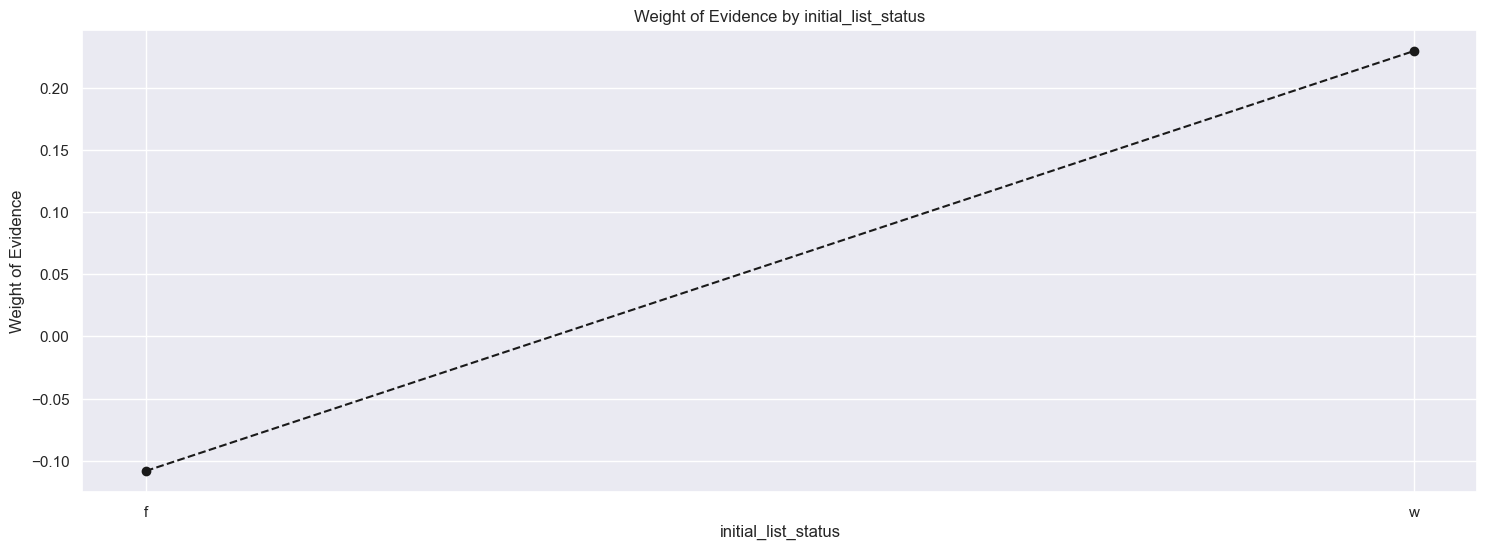

In [29]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

## 2. Preprocessing Continous Variables : Create Dummy Variables

### Creating function for weight of evidence encoding for continous variables

In [30]:
# WoE function for ordered discrete and continuous variables
def woe_ordered_continuous(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we define a function similar to the one above, ...
# ... with one slight difference: we order the results by the values of a different column.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

### 1. Variable : Term_int

In [31]:
# term
df_inputs_prepr['term_int'].unique()
# There are only two unique values, 36 and 60.

array([36, 60])

In [32]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'term_int', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,term_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,270419,0.902995,0.724929,244187.0,26232.0,0.73495,0.643288,0.133209,NaN,NaN,0.039434
1,60,102609,0.858239,0.275071,88063.0,14546.0,0.26505,0.356712,-0.297009,0.044756,0.430218,0.039434


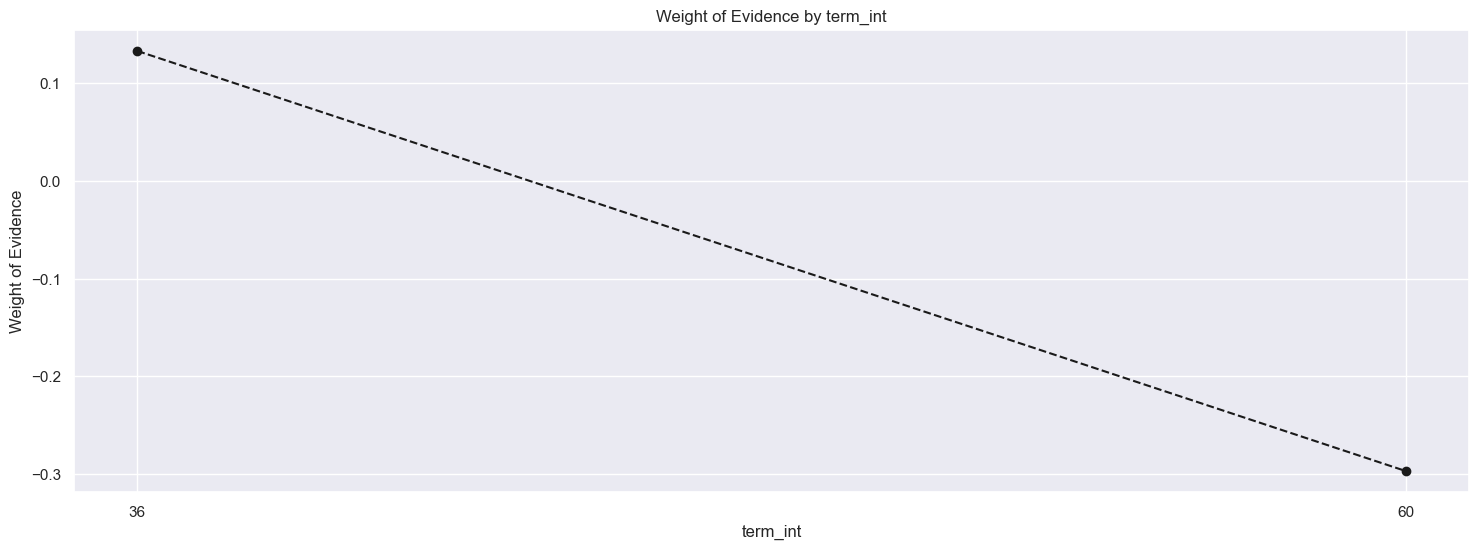

In [33]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [34]:
# Leave as is.
# '60' will be the reference category.
df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term_int'] == 36), 1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term_int'] == 60), 1, 0)

### 2. Variable: emp_length_int

In [35]:
# emp_length_int
df_inputs_prepr['emp_length_int'].unique()
# Has only 11 levels: from 0 to 10. Hence, we turn it into a factor with 11 levels.

array([ 3,  6, 10,  7,  5,  0,  2,  9,  1,  8,  4])

In [36]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'emp_length_int', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,emp_length_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0,45720,0.876400,0.122565,40069.0,5651.0,0.120599,0.138580,-0.138975,NaN,NaN,0.006506
1,1,23654,0.886996,0.063411,20981.0,2673.0,0.063148,0.065550,-0.037329,0.010596,0.101645,0.006506
2,2,33078,0.890955,0.088674,29471.0,3607.0,0.088701,0.088455,0.002785,0.003959,0.040114,0.006506
3,3,29205,0.890772,0.078292,26015.0,3190.0,0.078299,0.078228,0.000907,0.000183,0.001878,0.006506
4,4,22468,0.890644,0.060231,20011.0,2457.0,0.060229,0.060253,-0.000404,0.000128,0.001311,0.006506
5,5,24602,0.884725,0.065952,21766.0,2836.0,0.065511,0.069547,-0.059790,0.005920,0.059387,0.006506
6,6,20887,0.883899,0.055993,18462.0,2425.0,0.055567,0.059468,-0.067862,0.000826,0.008071,0.006506
7,7,21049,0.887453,0.056427,18680.0,2369.0,0.056223,0.058095,-0.032759,0.003554,0.035102,0.006506
8,8,17853,0.889878,0.047860,15887.0,1966.0,0.047816,0.048212,-0.008245,0.002425,0.024515,0.006506
9,9,14267,0.886662,0.038246,12650.0,1617.0,0.038074,0.039654,-0.040660,0.003217,0.032416,0.006506


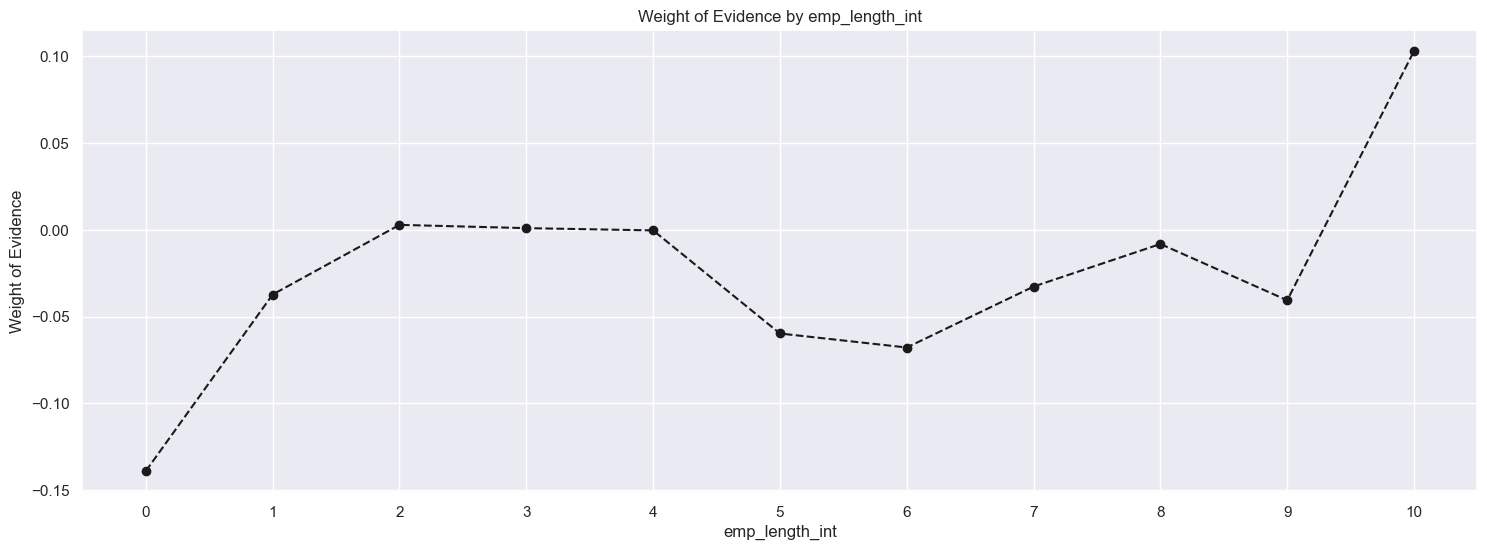

In [37]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [38]:
# We create the following categories: '0', '1', '2 - 4', '5 - 6', '7 - 9', '10'
# '0' will be the reference category
df_inputs_prepr['emp_length:0'] = np.where(df_inputs_prepr['emp_length_int'].isin([0]), 1, 0)
df_inputs_prepr['emp_length:1'] = np.where(df_inputs_prepr['emp_length_int'].isin([1]), 1, 0)
df_inputs_prepr['emp_length:2-4'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(2, 5)), 1, 0)
df_inputs_prepr['emp_length:5-6'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(5, 7)), 1, 0)
df_inputs_prepr['emp_length:7-9'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(7, 10)), 1, 0)
df_inputs_prepr['emp_length:10'] = np.where(df_inputs_prepr['emp_length_int'].isin([10]), 1, 0)

### 3. Variable: mnths_since_issue_d

In [39]:
df_inputs_prepr['mths_since_issue_d'].unique()

array([ 44.,  63.,  53.,  43.,  99.,  36.,  89.,  52.,  41.,  56.,  57.,
        42.,  39.,  50.,  58., 111.,  49.,  61.,  48.,  46.,  47.,  40.,
        37.,  65.,  68.,  85.,  45.,  75.,  62.,  38.,  60.,  87.,  64.,
        55.,  78.,  67.,  51.,  59.,  72.,  73.,  69.,  86.,  80.,  54.,
       101.,  81.,  71.,  83.,  35.,  70.,  90.,  76.,  66.,  82.,  84.,
        88., 114.,  91.,  93.,  77.,  74.,  79.,  94.,  92.,  96., 102.,
       123., 103., 116., 108., 117., 112.,  95., 100., 104.,  98., 120.,
       119., 106., 115., 118., 122.,  97., 113., 110., 107., 121., 105.,
       124., 109.])

In [40]:
df_inputs_prepr['mths_since_issue_d_factor'] = pd.cut(df_inputs_prepr['mths_since_issue_d'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.

In [41]:
df_inputs_prepr['mths_since_issue_d_factor']

427211      (43.9, 45.68]
206088      (61.7, 63.48]
136020      (52.8, 54.58]
412305      (42.12, 43.9]
36159       (97.3, 99.08]
               ...       
259178    (34.911, 36.78]
365838     (40.34, 42.12]
131932      (52.8, 54.58]
146867     (54.58, 56.36]
121958      (51.02, 52.8]
Name: mths_since_issue_d_factor, Length: 373028, dtype: category
Categories (50, interval[float64, right]): [(34.911, 36.78] < (36.78, 38.56] < (38.56, 40.34] < (40.34, 42.12] ... (116.88, 118.66] < (118.66, 120.44] < (120.44, 122.22] < (122.22, 124.0]]

In [42]:
# mths_since_issue_d
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_issue_d_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,mths_since_issue_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(34.911, 36.78]",28170,0.942244,0.075517,26543.0,1627.0,0.079889,0.039899,0.694283,NaN,NaN,0.113075
1,"(36.78, 38.56]",39636,0.928424,0.106255,36799.0,2837.0,0.110757,0.069572,0.464979,0.013820,0.229305,0.113075
2,"(38.56, 40.34]",38614,0.917284,0.103515,35420.0,3194.0,0.106606,0.078327,0.308258,0.011140,0.156721,0.113075
3,"(40.34, 42.12]",29038,0.908603,0.077844,26384.0,2654.0,0.079410,0.065084,0.198945,0.008681,0.109313,0.113075
4,"(42.12, 43.9]",15250,0.901377,0.040882,13746.0,1504.0,0.041372,0.036883,0.114875,0.007225,0.084070,0.113075
5,"(43.9, 45.68]",25282,0.900839,0.067775,22775.0,2507.0,0.068548,0.061479,0.108832,0.000539,0.006043,0.113075
6,"(45.68, 47.46]",24451,0.898900,0.065547,21979.0,2472.0,0.066152,0.060621,0.087315,0.001939,0.021517,0.113075
7,"(47.46, 49.24]",22969,0.888328,0.061574,20404.0,2565.0,0.061412,0.062902,-0.023972,0.010572,0.111287,0.113075
8,"(49.24, 51.02]",20640,0.880523,0.055331,18174.0,2466.0,0.054700,0.060474,-0.100350,0.007804,0.076378,0.113075
9,"(51.02, 52.8]",9560,0.871548,0.025628,8332.0,1228.0,0.025078,0.030114,-0.183028,0.008975,0.082678,0.113075


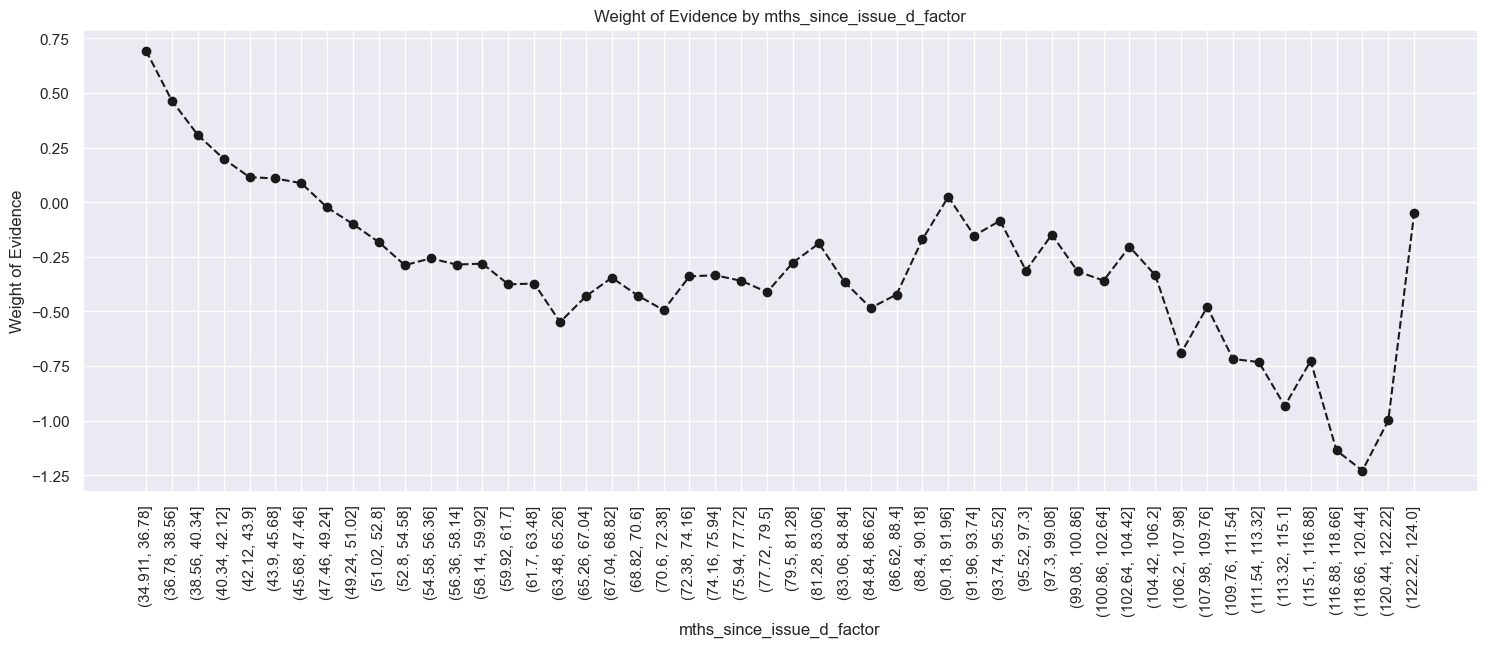

In [43]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values, rotating the labels 90 degrees.

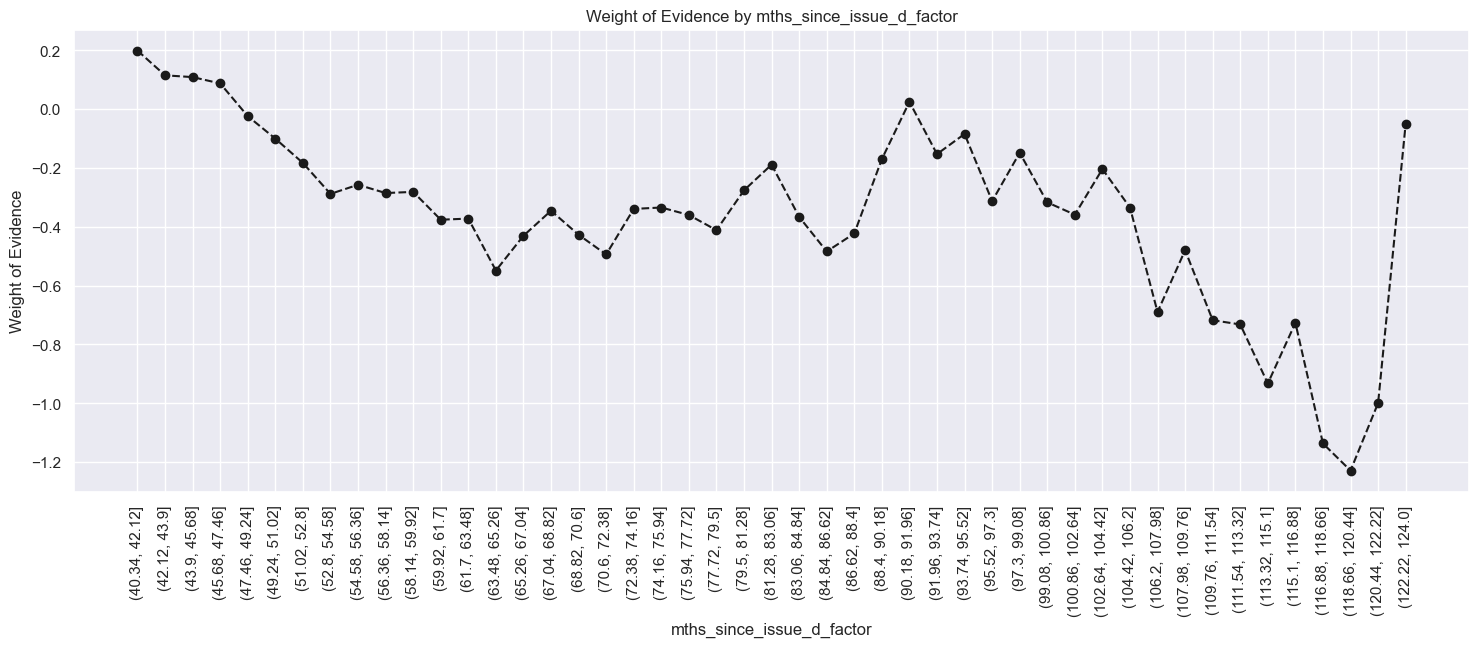

In [44]:
plot_by_woe(df_temp.iloc[3: , : ], 90)
# We plot the weight of evidence values.

In [45]:
# We create the following categories:
# < 38, 38 - 39, 40 - 41, 42 - 48, 49 - 52, 53 - 64, 65 - 84, > 84.
df_inputs_prepr['mths_since_issue_d:<38'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38)), 1, 0)
df_inputs_prepr['mths_since_issue_d:38-39'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
df_inputs_prepr['mths_since_issue_d:40-41'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
df_inputs_prepr['mths_since_issue_d:42-48'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
df_inputs_prepr['mths_since_issue_d:49-52'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
df_inputs_prepr['mths_since_issue_d:53-64'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
df_inputs_prepr['mths_since_issue_d:65-84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
df_inputs_prepr['mths_since_issue_d:>84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(85, int(df_inputs_prepr['mths_since_issue_d'].max()))), 1, 0)

### 4. Variable: int_rate_factor

In [46]:
# int_rate
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.

In [47]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'int_rate_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.399, 5.833]",785,0.961783,0.002104,755.0,30.0,0.002272,0.000736,1.127775,NaN,NaN,0.343349
1,"(5.833, 6.246]",8459,0.980376,0.022677,8293.0,166.0,0.024960,0.004071,1.813434,0.018592,0.685659,0.343349
2,"(6.246, 6.658]",7826,0.971505,0.020980,7603.0,223.0,0.022883,0.005469,1.431381,0.008871,0.382053,0.343349
3,"(6.658, 7.071]",1816,0.973018,0.004868,1767.0,49.0,0.005318,0.001202,1.487473,0.001512,0.056092,0.343349
4,"(7.071, 7.484]",3143,0.976456,0.008426,3069.0,74.0,0.009237,0.001815,1.627297,0.003438,0.139824,0.343349
5,"(7.484, 7.897]",12581,0.962324,0.033727,12107.0,474.0,0.036439,0.011624,1.142587,0.014131,0.484710,0.343349
6,"(7.897, 8.31]",9687,0.949314,0.025969,9196.0,491.0,0.027678,0.012041,0.832335,0.013011,0.310252,0.343349
7,"(8.31, 8.722]",6594,0.965271,0.017677,6365.0,229.0,0.019157,0.005616,1.227103,0.015958,0.394768,0.343349
8,"(8.722, 9.135]",9539,0.937415,0.025572,8942.0,597.0,0.026913,0.014640,0.608852,0.027857,0.618250,0.343349
9,"(9.135, 9.548]",6681,0.963928,0.017910,6440.0,241.0,0.019383,0.005910,1.187742,0.026513,0.578889,0.343349


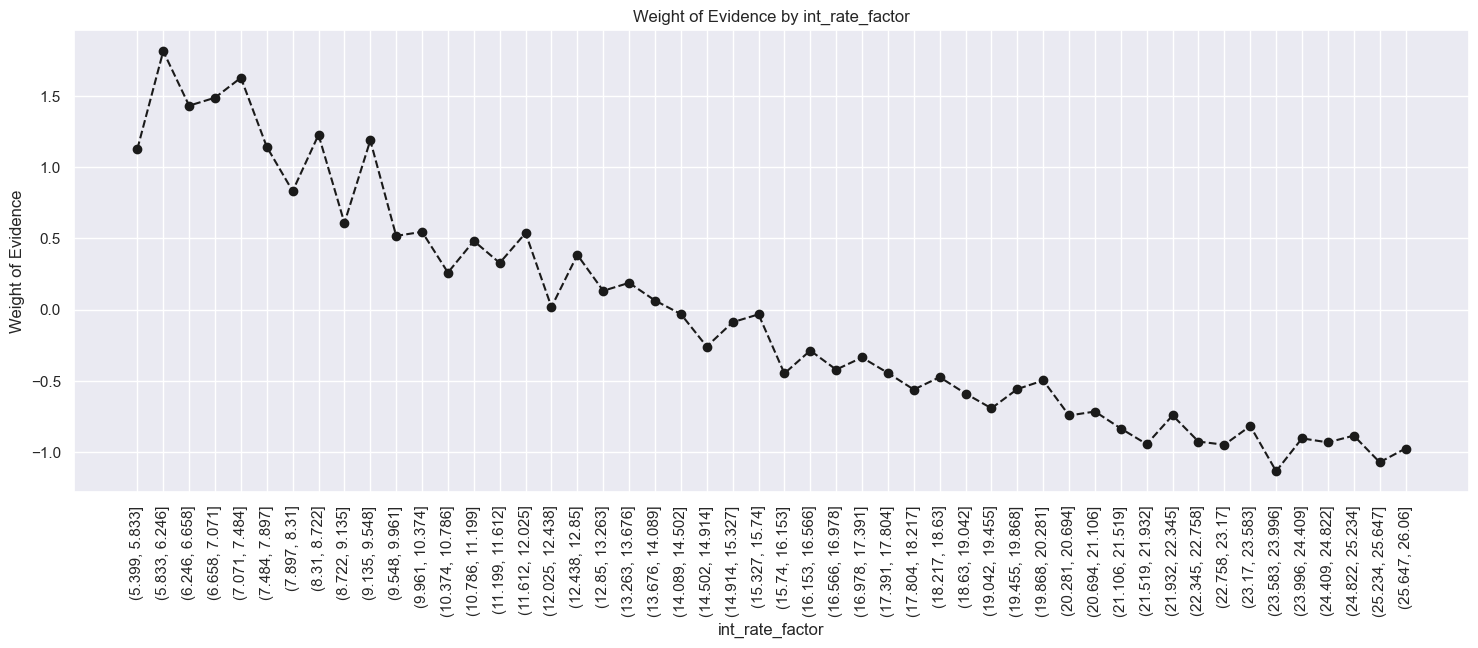

In [48]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [49]:
# '< 9.548', '9.548 - 12.025', '12.025 - 15.74', '15.74 - 20.281', '> 20.281'

In [50]:
df_inputs_prepr['int_rate:<9.548'] = np.where((df_inputs_prepr['int_rate'] <= 9.548), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:12.025-15.74'] = np.where((df_inputs_prepr['int_rate'] > 12.025) & (df_inputs_prepr['int_rate'] <= 15.74), 1, 0)
df_inputs_prepr['int_rate:15.74-20.281'] = np.where((df_inputs_prepr['int_rate'] > 15.74) & (df_inputs_prepr['int_rate'] <= 20.281), 1, 0)
df_inputs_prepr['int_rate:>20.281'] = np.where((df_inputs_prepr['int_rate'] > 20.281), 1, 0)

### 5. Variable: funded_amnt_factor

In [51]:
df_inputs_prepr['funded_amnt'].describe()

count    373028.000000
mean      14292.326514
std        8275.446272
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: funded_amnt, dtype: float64

In [52]:
# funded_amnt
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'funded_amnt_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,funded_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(465.5, 1190.0]",1224,0.905229,0.003281,1108.0,116.0,0.003335,0.002845,0.158977,NaN,NaN,0.014139
1,"(1190.0, 1880.0]",3028,0.903897,0.008117,2737.0,291.0,0.008238,0.007136,0.143549,0.001332,0.015427,0.014139
2,"(1880.0, 2570.0]",6018,0.893819,0.016133,5379.0,639.0,0.016190,0.015670,0.032608,0.010078,0.110941,0.014139
3,"(2570.0, 3260.0]",7248,0.889073,0.019430,6444.0,804.0,0.019395,0.019717,-0.016440,0.004746,0.049048,0.014139
4,"(3260.0, 3950.0]",4751,0.891602,0.012736,4236.0,515.0,0.012749,0.012629,0.009463,0.002529,0.025902,0.014139
5,"(3950.0, 4640.0]",9023,0.890945,0.024189,8039.0,984.0,0.024196,0.024131,0.002689,0.000656,0.006774,0.014139
6,"(4640.0, 5330.0]",15903,0.892159,0.042632,14188.0,1715.0,0.042703,0.042057,0.015238,0.001213,0.012549,0.014139
7,"(5330.0, 6020.0]",17236,0.906069,0.046206,15617.0,1619.0,0.047004,0.039703,0.168806,0.013910,0.153568,0.014139
8,"(6020.0, 6710.0]",6914,0.887619,0.018535,6137.0,777.0,0.018471,0.019054,-0.031094,0.018449,0.199900,0.014139
9,"(6710.0, 7400.0]",11806,0.898018,0.031649,10602.0,1204.0,0.031910,0.029526,0.077648,0.010399,0.108742,0.014139


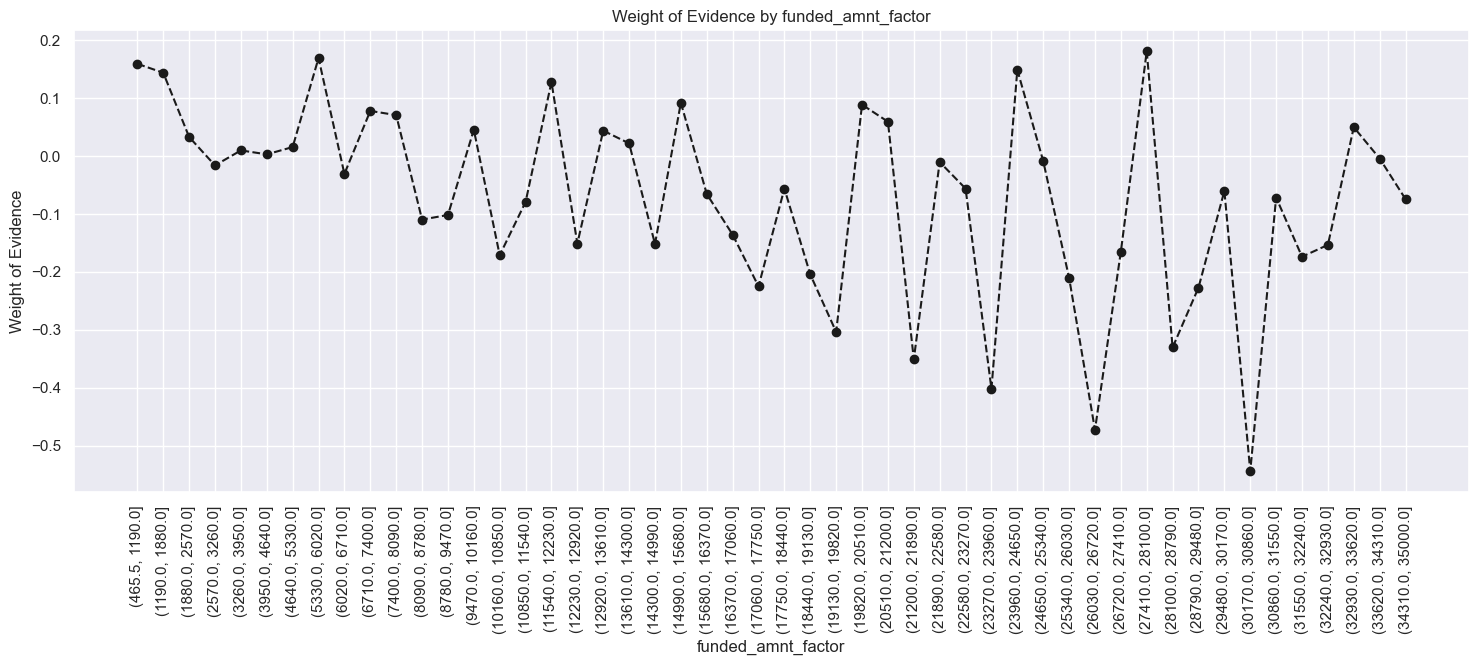

In [53]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

### 6. Variable: mths_since_earliest_cr_line_factor

In [54]:
df_inputs_prepr['mnths_since_earliest_cr_line'].describe()

count    373028.000000
mean        238.099687
std          85.452836
min           0.000000
25%         180.000000
50%         222.000000
75%         280.000000
max         871.000000
Name: mnths_since_earliest_cr_line, dtype: float64

In [55]:
# mths_since_earliest_cr_line
df_inputs_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(df_inputs_prepr['mnths_since_earliest_cr_line'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_earliest_cr_line_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.871, 17.42]",24,0.875000,0.000064,21.0,3.0,0.000063,0.000074,-0.151835,NaN,NaN,inf
1,"(17.42, 34.84]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2,"(34.84, 52.26]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(52.26, 69.68]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
4,"(69.68, 87.1]",1983,0.897630,0.005316,1780.0,203.0,0.005357,0.004978,0.073418,NaN,NaN,inf
5,"(87.1, 104.52]",3705,0.860459,0.009932,3188.0,517.0,0.009595,0.012678,-0.278639,0.037171,0.352056,inf
6,"(104.52, 121.94]",9022,0.866770,0.024186,7820.0,1202.0,0.023536,0.029477,-0.225047,0.006311,0.053592,inf
7,"(121.94, 139.36]",18690,0.867041,0.050103,16205.0,2485.0,0.048774,0.060940,-0.222698,0.000271,0.002349,inf
8,"(139.36, 156.78]",20970,0.877158,0.056216,18394.0,2576.0,0.055362,0.063171,-0.131958,0.010117,0.090740,inf
9,"(156.78, 174.2]",27877,0.882448,0.074732,24600.0,3277.0,0.074041,0.080362,-0.081927,0.005290,0.050031,inf


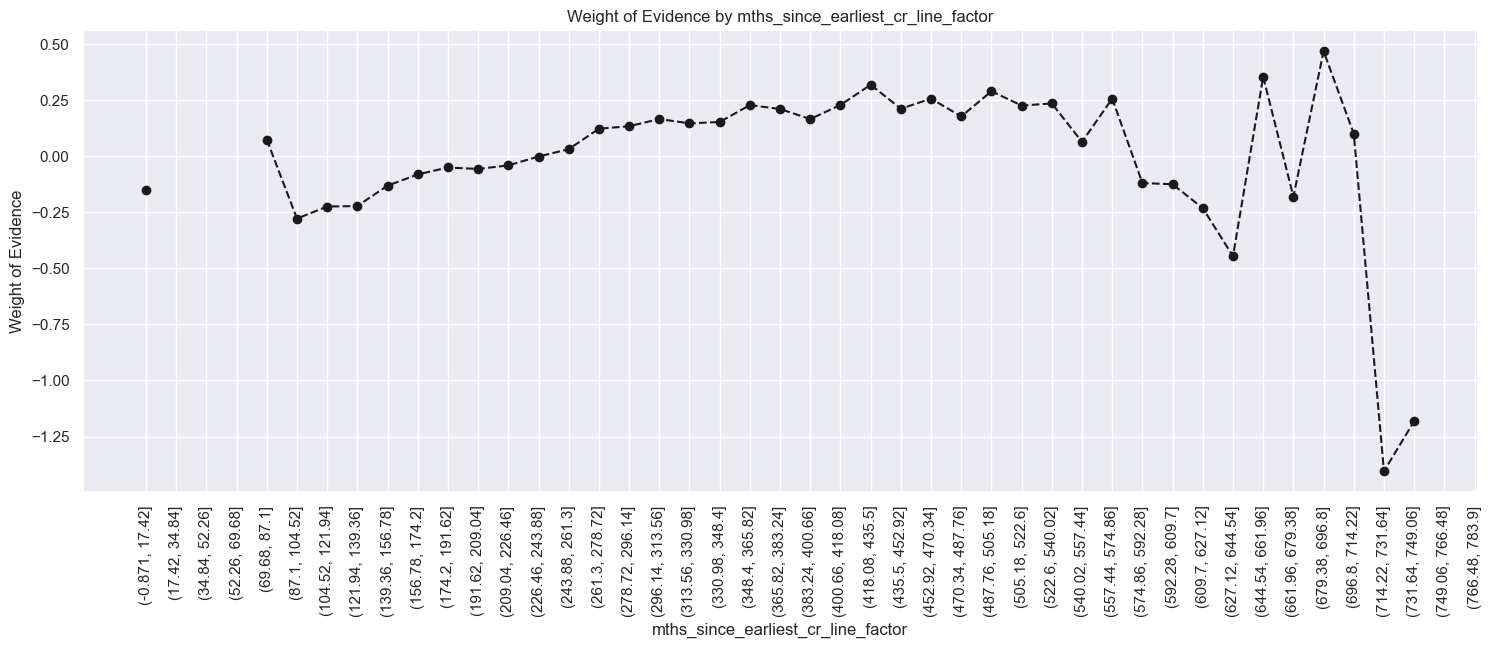

In [56]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

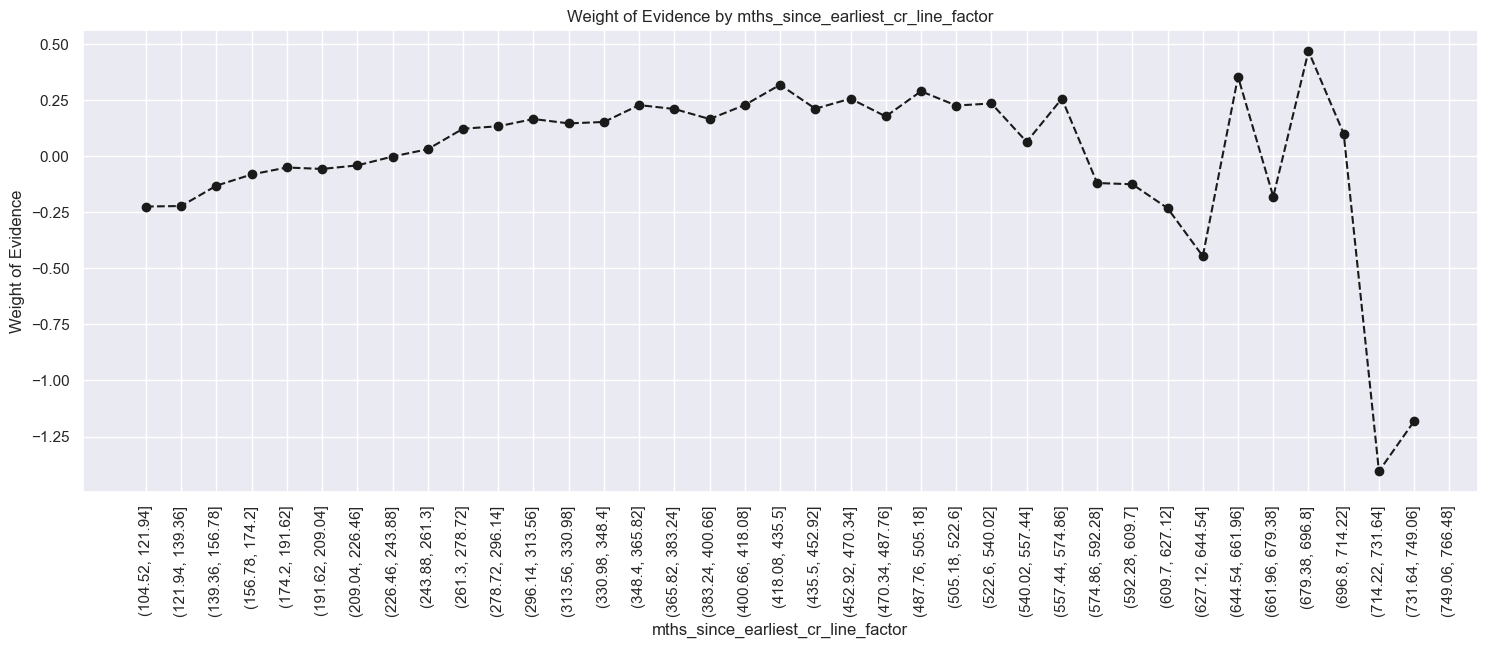

In [57]:
plot_by_woe(df_temp.iloc[6: , : ], 90)
# We plot the weight of evidence values.

In [58]:
# We create the following categories:
# < 140, # 141 - 164, # 165 - 247, # 248 - 270, # 271 - 352, # > 352
df_inputs_prepr['mnths_since_earliest_cr_line:<140'] = np.where(df_inputs_prepr['mnths_since_earliest_cr_line'].isin(range(140)), 1, 0)
df_inputs_prepr['mnths_since_earliest_cr_line:141-164'] = np.where(df_inputs_prepr['mnths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
df_inputs_prepr['mnths_since_earliest_cr_line:165-247'] = np.where(df_inputs_prepr['mnths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
df_inputs_prepr['mnths_since_earliest_cr_line:248-270'] = np.where(df_inputs_prepr['mnths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
df_inputs_prepr['mnths_since_earliest_cr_line:271-352'] = np.where(df_inputs_prepr['mnths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
df_inputs_prepr['mnths_since_earliest_cr_line:>352'] = np.where(df_inputs_prepr['mnths_since_earliest_cr_line'].isin(range(353, int(df_inputs_prepr['mnths_since_earliest_cr_line'].max()))), 1, 0)

### 7. Variable: delinq_2yrs

In [59]:
df_inputs_prepr['delinq_2yrs'].describe()

count    373028.000000
mean          0.284359
std           0.796584
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          29.000000
Name: delinq_2yrs, dtype: float64

In [60]:
# delinq_2yrs
df_temp = woe_ordered_continuous(df_inputs_prepr, 'delinq_2yrs', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,delinq_2yrs,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,306417,0.890499,0.821432,272864.0,33553.0,0.821261,0.822821,-0.001898,NaN,NaN,inf
1,1.0,44927,0.893249,0.120439,40131.0,4796.0,0.120786,0.117612,0.026622,0.002750,0.028520,inf
2,2.0,13118,0.889007,0.035166,11662.0,1456.0,0.035100,0.035706,-0.017102,0.004242,0.043724,inf
3,3.0,4550,0.883297,0.012197,4019.0,531.0,0.012096,0.013022,-0.073719,0.005711,0.056616,inf
4,4.0,1868,0.898822,0.005008,1679.0,189.0,0.005053,0.004635,0.086462,0.015526,0.160180,inf
5,5.0,966,0.881988,0.002590,852.0,114.0,0.002564,0.002796,-0.086357,0.016835,0.172819,inf
6,6.0,501,0.902196,0.001343,452.0,49.0,0.001360,0.001202,0.124117,0.020208,0.210474,inf
7,7.0,279,0.860215,0.000748,240.0,39.0,0.000722,0.000956,-0.280668,0.041981,0.404785,inf
8,8.0,148,0.905405,0.000397,134.0,14.0,0.000403,0.000343,0.161037,0.045190,0.441705,inf
9,9.0,89,0.887640,0.000239,79.0,10.0,0.000238,0.000245,-0.030882,0.017765,0.191920,inf


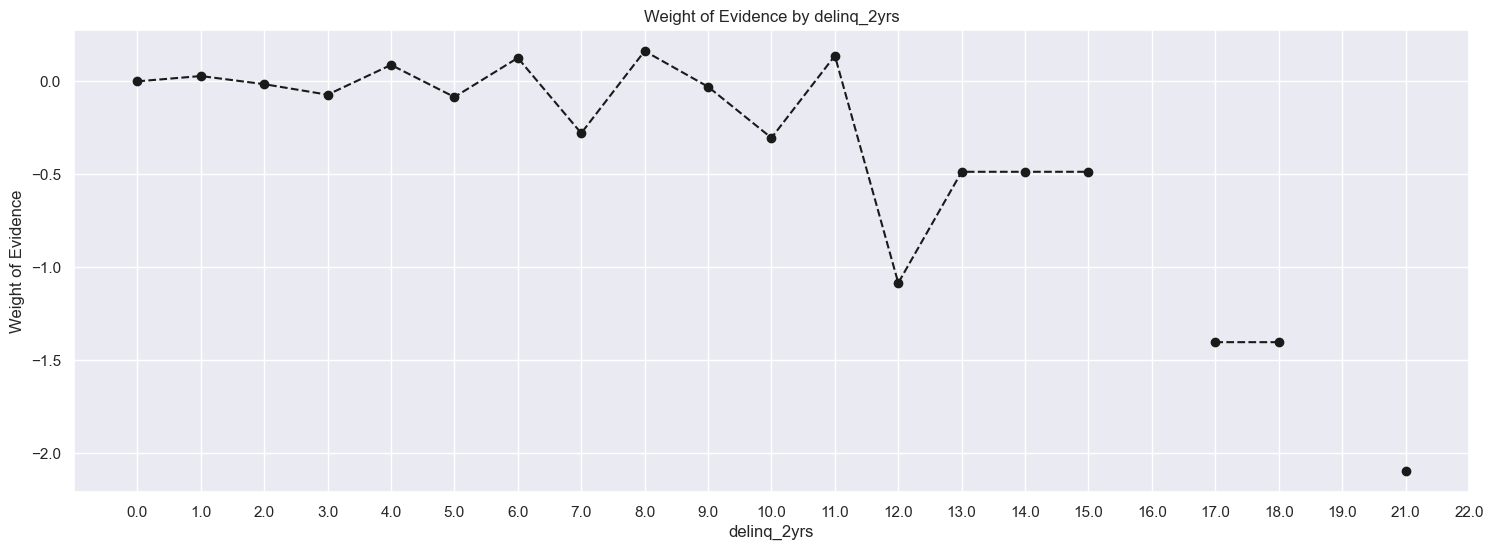

In [61]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [62]:
# Categories: 0, 1-3, >=4
df_inputs_prepr['delinq_2yrs:0'] = np.where((df_inputs_prepr['delinq_2yrs'] == 0), 1, 0)
df_inputs_prepr['delinq_2yrs:1-3'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 1) & (df_inputs_prepr['delinq_2yrs'] <= 3), 1, 0)
df_inputs_prepr['delinq_2yrs:>=4'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 9), 1, 0)

### 8 . Variable: inq_last_6mnths

In [63]:
df_inputs_prepr['inq_last_6mths'].describe()

count    373028.000000
mean          0.804859
std           1.093220
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          33.000000
Name: inq_last_6mths, dtype: float64

In [64]:
# inq_last_6mths
df_temp = woe_ordered_continuous(df_inputs_prepr, 'inq_last_6mths', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/Users/pr7/Documents/github/credit-risk-modeling/creditEnvironment/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,193232,0.908395,0.518009,175531.0,17701.0,0.528310,0.434082,0.196450,NaN,NaN,inf
1,1.0,104163,0.884950,0.279236,92179.0,11984.0,0.277439,0.293884,-0.057585,0.023446,0.254035,inf
2,2.0,46214,0.864197,0.123889,39938.0,6276.0,0.120205,0.153907,-0.247150,0.020753,0.189564,inf
3,3.0,20040,0.839671,0.053723,16827.0,3213.0,0.050646,0.078792,-0.441965,0.024526,0.194816,inf
4,4.0,5810,0.848365,0.015575,4929.0,881.0,0.014835,0.021605,-0.375911,0.008694,0.066054,inf
5,5.0,2217,0.824989,0.005943,1829.0,388.0,0.005505,0.009515,-0.547226,0.023376,0.171314,inf
6,6.0,977,0.788127,0.002619,770.0,207.0,0.002318,0.005076,-0.784073,0.036862,0.236848,inf
7,7.0,159,0.679245,0.000426,108.0,51.0,0.000325,0.001251,-1.347439,0.108882,0.563366,inf
8,8.0,101,0.643564,0.000271,65.0,36.0,0.000196,0.000883,-1.506877,0.035681,0.159437,inf
9,9.0,43,0.674419,0.000115,29.0,14.0,0.000087,0.000343,-1.369506,0.030854,0.137370,inf


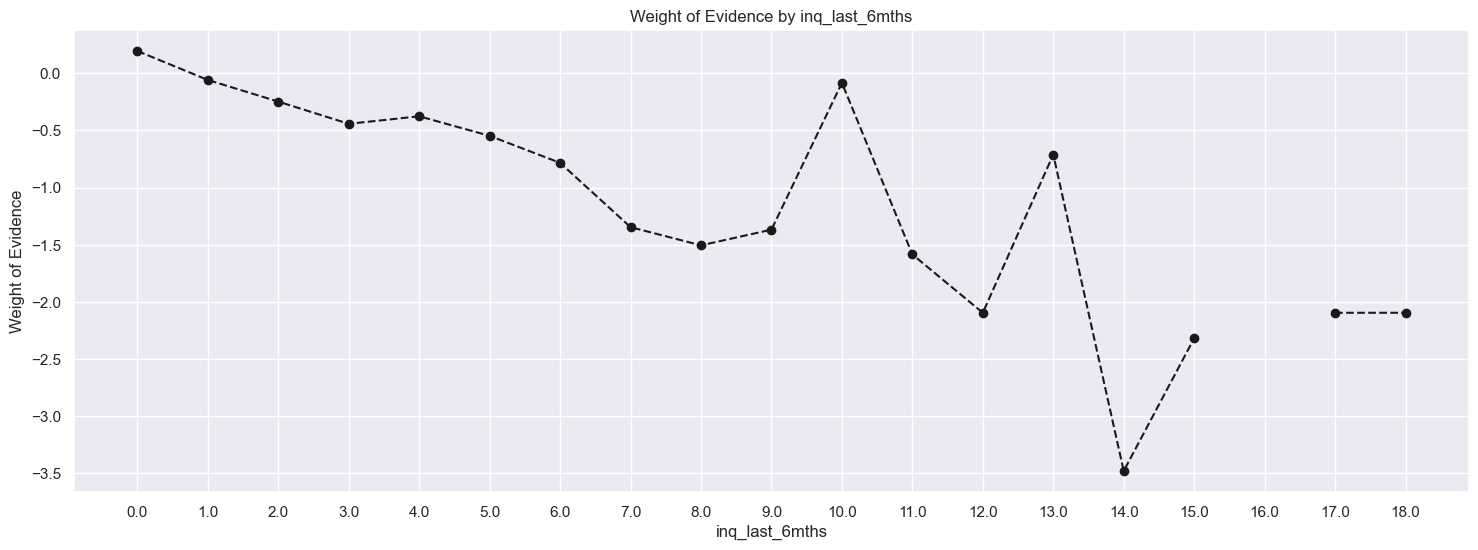

In [65]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [66]:
# Categories: 0, 1 - 2, 3 - 6, > 6
df_inputs_prepr['inq_last_6mths:0'] = np.where((df_inputs_prepr['inq_last_6mths'] == 0), 1, 0)
df_inputs_prepr['inq_last_6mths:1-2'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 1) & (df_inputs_prepr['inq_last_6mths'] <= 2), 1, 0)
df_inputs_prepr['inq_last_6mths:3-6'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 3) & (df_inputs_prepr['inq_last_6mths'] <= 6), 1, 0)
df_inputs_prepr['inq_last_6mths:>6'] = np.where((df_inputs_prepr['inq_last_6mths'] > 6), 1, 0)

### 9. Variable: open_acc

In [67]:
df_inputs_prepr['open_acc'].describe()

count    373028.000000
mean         11.185579
std           4.984202
min           0.000000
25%           8.000000
50%          10.000000
75%          14.000000
max          84.000000
Name: open_acc, dtype: float64

In [68]:
# open_acc
df_temp = woe_ordered_continuous(df_inputs_prepr, 'open_acc', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/Users/pr7/Documents/github/credit-risk-modeling/creditEnvironment/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,open_acc,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,29,0.758621,0.000078,22.0,7.0,0.000066,0.000172,-0.952613,NaN,NaN,inf
1,1.0,110,0.872727,0.000295,96.0,14.0,0.000289,0.000343,-0.172454,0.114107,0.780159,inf
2,2.0,1456,0.845467,0.003903,1231.0,225.0,0.003705,0.005518,-0.398263,0.027260,0.225809,inf
3,3.0,4378,0.873687,0.011736,3825.0,553.0,0.011512,0.013561,-0.163789,0.028220,0.234474,inf
4,4.0,10028,0.891504,0.026883,8940.0,1088.0,0.026907,0.026681,0.008449,0.017817,0.172239,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
56,58.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.000000,NaN,inf
57,62.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.000000,NaN,inf
58,75.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.000000,NaN,inf
59,76.0,2,0.000000,0.000005,0.0,2.0,0.000000,0.000049,-inf,1.000000,inf,inf


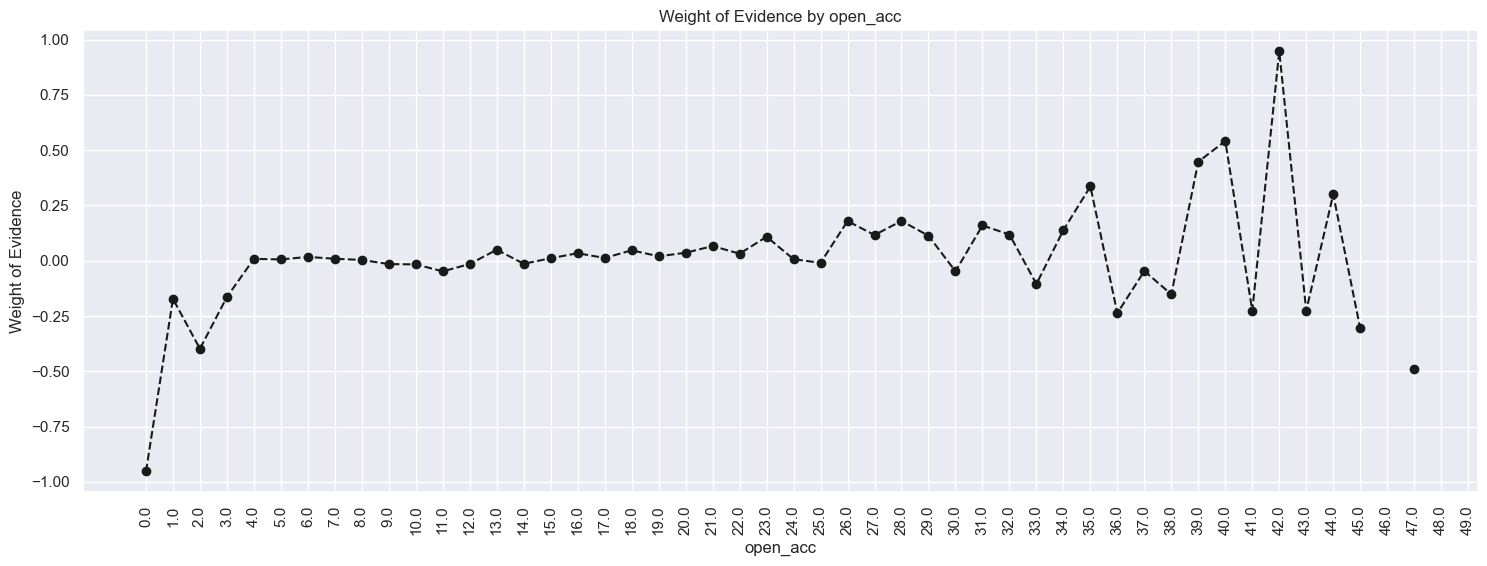

In [69]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

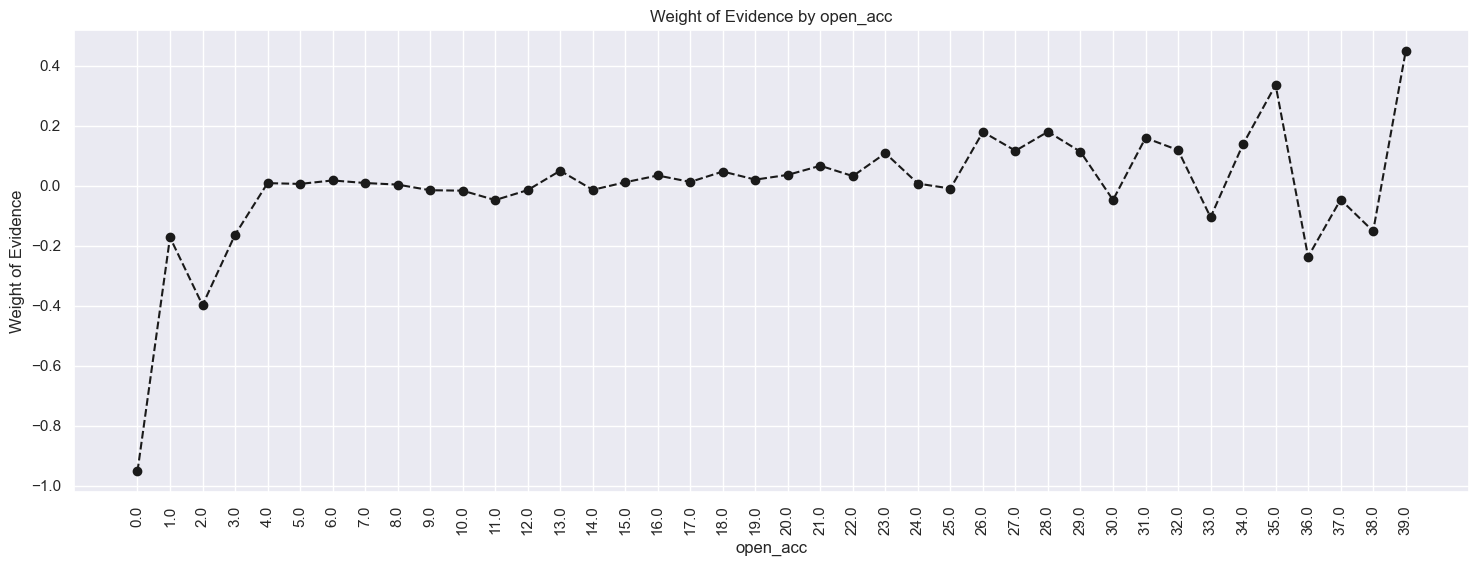

In [70]:
plot_by_woe(df_temp.iloc[ : 40, :], 90)
# We plot the weight of evidence values.

In [71]:
# Categories: '0', '1-3', '4-12', '13-17', '18-22', '23-25', '26-30', '>30'
df_inputs_prepr['open_acc:0'] = np.where((df_inputs_prepr['open_acc'] == 0), 1, 0)
df_inputs_prepr['open_acc:1-3'] = np.where((df_inputs_prepr['open_acc'] >= 1) & (df_inputs_prepr['open_acc'] <= 3), 1, 0)
df_inputs_prepr['open_acc:4-12'] = np.where((df_inputs_prepr['open_acc'] >= 4) & (df_inputs_prepr['open_acc'] <= 12), 1, 0)
df_inputs_prepr['open_acc:13-17'] = np.where((df_inputs_prepr['open_acc'] >= 13) & (df_inputs_prepr['open_acc'] <= 17), 1, 0)
df_inputs_prepr['open_acc:18-22'] = np.where((df_inputs_prepr['open_acc'] >= 18) & (df_inputs_prepr['open_acc'] <= 22), 1, 0)
df_inputs_prepr['open_acc:23-25'] = np.where((df_inputs_prepr['open_acc'] >= 23) & (df_inputs_prepr['open_acc'] <= 25), 1, 0)
df_inputs_prepr['open_acc:26-30'] = np.where((df_inputs_prepr['open_acc'] >= 26) & (df_inputs_prepr['open_acc'] <= 30), 1, 0)
df_inputs_prepr['open_acc:>=31'] = np.where((df_inputs_prepr['open_acc'] >= 31), 1, 0)

### 10. Variable: pub_rec

In [72]:
df_inputs_prepr['pub_rec'].describe()

count    373028.000000
mean          0.160213
std           0.509876
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          63.000000
Name: pub_rec, dtype: float64

In [73]:
# pub_rec
df_temp = woe_ordered_continuous(df_inputs_prepr, 'pub_rec', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,pub_rec,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,323999,0.889941,0.868565,288340.0,35659.0,0.867840,0.874467,-0.007606,NaN,NaN,inf
1,1.0,42381,0.893419,0.113613,37864.0,4517.0,0.113962,0.110771,0.028408,0.003478,0.036014,inf
2,2.0,4527,0.903247,0.012136,4089.0,438.0,0.012307,0.010741,0.136092,0.009828,0.107684,inf
3,3.0,1280,0.920312,0.003431,1178.0,102.0,0.003546,0.002501,0.348856,0.017065,0.212764,inf
4,4.0,408,0.924020,0.001094,377.0,31.0,0.001135,0.000760,0.400513,0.003707,0.051657,inf
5,5.0,203,0.911330,0.000544,185.0,18.0,0.000557,0.000441,0.232239,0.012690,0.168274,inf
6,6.0,117,0.931624,0.000314,109.0,8.0,0.000328,0.000196,0.514161,0.020294,0.281922,inf
7,7.0,48,0.958333,0.000129,46.0,2.0,0.000138,0.000049,1.037749,0.026709,0.523588,inf
8,8.0,24,1.000000,0.000064,24.0,0.0,0.000072,0.000000,inf,0.041667,inf,inf
9,9.0,14,0.785714,0.000038,11.0,3.0,0.000033,0.000074,-0.798462,0.214286,inf,inf


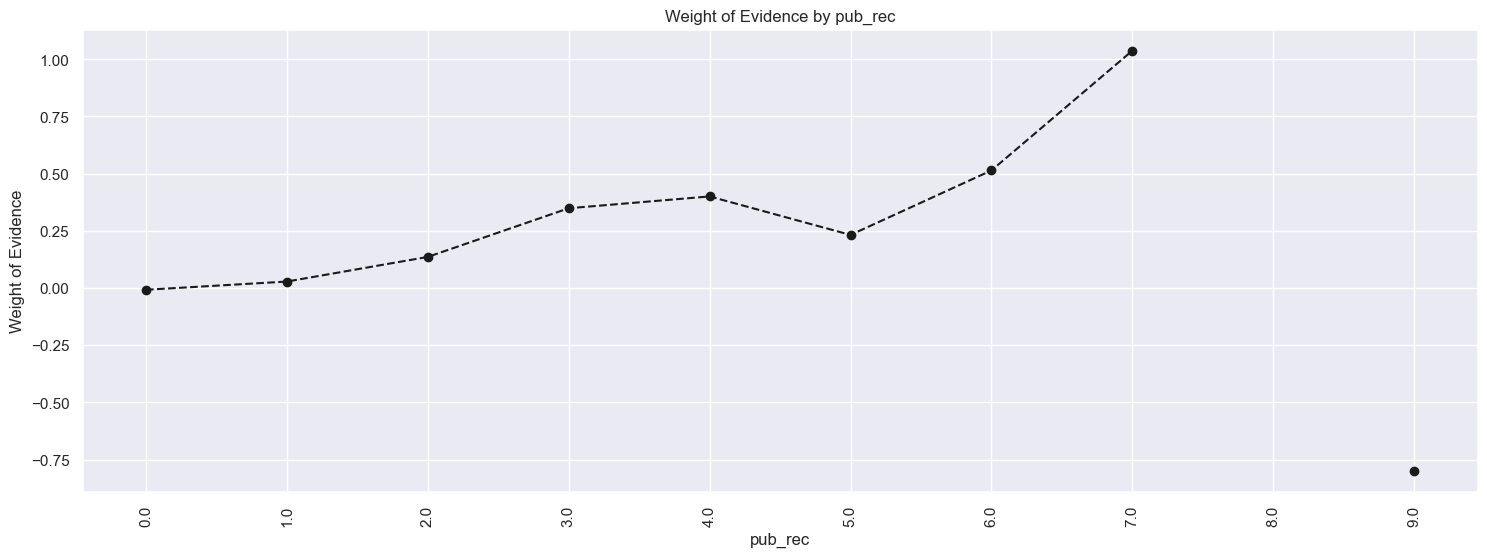

In [74]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [75]:
# Categories '0-2', '3-4', '>=5'
df_inputs_prepr['pub_rec:0-2'] = np.where((df_inputs_prepr['pub_rec'] >= 0) & (df_inputs_prepr['pub_rec'] <= 2), 1, 0)
df_inputs_prepr['pub_rec:3-4'] = np.where((df_inputs_prepr['pub_rec'] >= 3) & (df_inputs_prepr['pub_rec'] <= 4), 1, 0)
df_inputs_prepr['pub_rec:>=5'] = np.where((df_inputs_prepr['pub_rec'] >= 5), 1, 0)

### 11. Variable: total_acc

In [76]:
df_inputs_prepr['total_acc'].describe()

count    373028.000000
mean         25.061148
std          11.599953
min           0.000000
25%          17.000000
50%          23.000000
75%          32.000000
max         150.000000
Name: total_acc, dtype: float64

In [77]:
# total_acc
df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_acc_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.15, 3.0]",459,0.810458,0.001230,372.0,87.0,0.001120,0.002134,-0.644759,NaN,NaN,inf
1,"(3.0, 6.0]",6004,0.864757,0.016095,5192.0,812.0,0.015627,0.019913,-0.242371,0.054299,0.402388,inf
2,"(6.0, 9.0]",15047,0.873131,0.040337,13138.0,1909.0,0.039543,0.046814,-0.168816,0.008374,0.073555,inf
3,"(9.0, 12.0]",25169,0.881283,0.067472,22181.0,2988.0,0.066760,0.073275,-0.093113,0.008152,0.075703,inf
4,"(12.0, 15.0]",33651,0.881281,0.090210,29656.0,3995.0,0.089258,0.097969,-0.093124,0.000001,0.000011,inf
5,"(15.0, 18.0]",38711,0.887267,0.103775,34347.0,4364.0,0.103377,0.107018,-0.034619,0.005986,0.058505,inf
6,"(18.0, 21.0]",40599,0.886155,0.108836,35977.0,4622.0,0.108283,0.113345,-0.045693,0.001112,0.011073,inf
7,"(21.0, 24.0]",40163,0.891492,0.107668,35805.0,4358.0,0.107765,0.106871,0.008329,0.005337,0.054022,inf
8,"(24.0, 27.0]",36286,0.895442,0.097274,32492.0,3794.0,0.097794,0.093040,0.049828,0.003950,0.041499,inf
9,"(27.0, 30.0]",31775,0.899103,0.085181,28569.0,3206.0,0.085986,0.078621,0.089553,0.003661,0.039725,inf


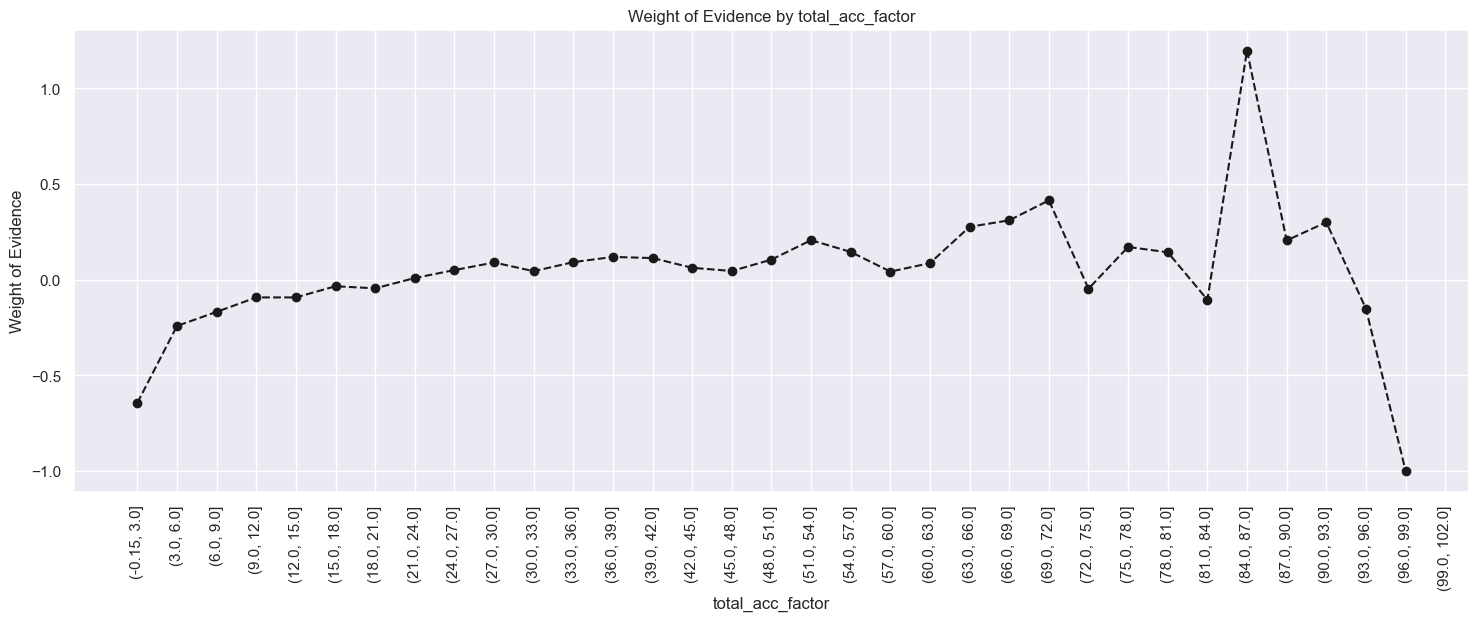

In [78]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [79]:
# Categories: '<=27', '28-51', '>51'
df_inputs_prepr['total_acc:<=27'] = np.where((df_inputs_prepr['total_acc'] <= 27), 1, 0)
df_inputs_prepr['total_acc:28-51'] = np.where((df_inputs_prepr['total_acc'] >= 28) & (df_inputs_prepr['total_acc'] <= 51), 1, 0)
df_inputs_prepr['total_acc:>=52'] = np.where((df_inputs_prepr['total_acc'] >= 52), 1, 0)

### 12. Variable: acc_now_delinq

In [80]:
df_inputs_prepr['acc_now_delinq'].unique()

array([0., 1., 2., 3., 4., 5.])

In [81]:
# acc_now_delinq
df_temp = woe_ordered_continuous(df_inputs_prepr, 'acc_now_delinq', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,acc_now_delinq,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,371682,0.890648,0.996392,331038.0,40644.0,0.996352,0.996714,-0.000363,NaN,NaN,inf
1,1.0,1263,0.899446,0.003386,1136.0,127.0,0.003419,0.003114,0.093337,0.008797,0.093700,inf
2,2.0,70,0.928571,0.000188,65.0,5.0,0.000196,0.000123,0.467204,0.029126,0.373868,inf
3,3.0,7,0.857143,0.000019,6.0,1.0,0.000018,0.000025,-0.305986,0.071429,0.773190,inf
4,4.0,4,1.000000,0.000011,4.0,0.0,0.000012,0.000000,inf,0.142857,inf,inf
5,5.0,2,0.500000,0.000005,1.0,1.0,0.000003,0.000025,-2.097745,0.500000,inf,inf


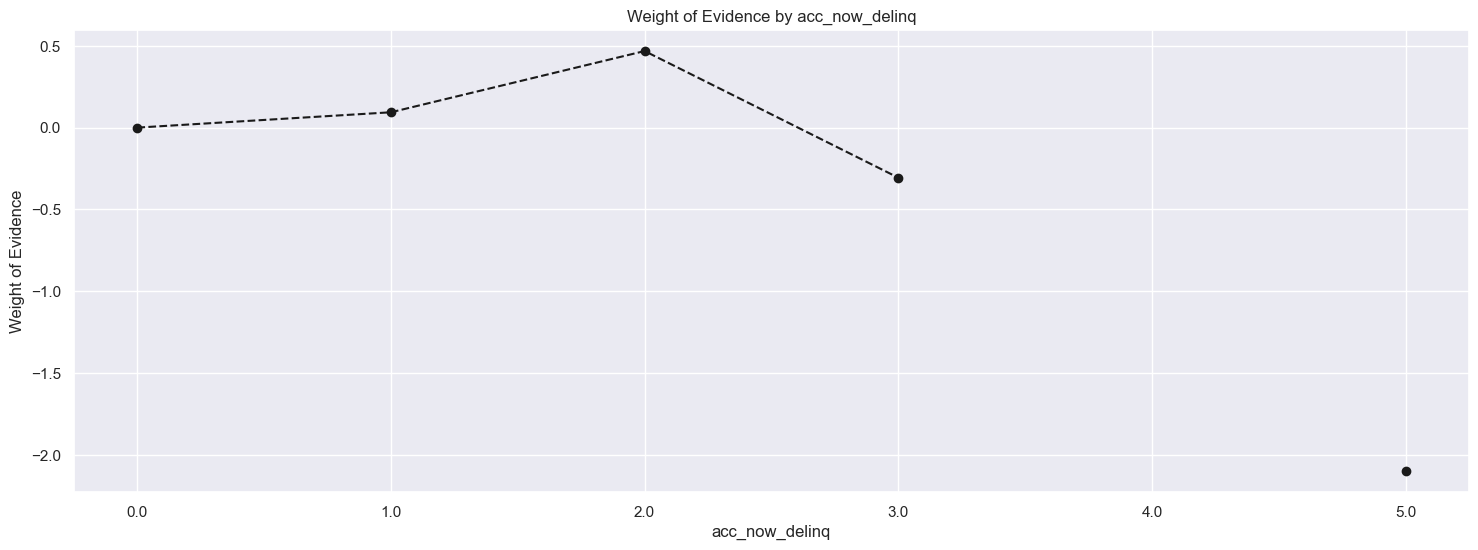

In [82]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [83]:
# Categories: '0', '>=1'
df_inputs_prepr['acc_now_delinq:0'] = np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq:>=1'] = np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

### Variable 13: total_rev_hi_lim

In [84]:
pd.set_option('display.float_format', '{:.0f}'.format)
df_inputs_prepr['total_rev_hi_lim'].describe()

count    373028
mean      27571
std       36376
min           0
25%       11600
50%       20100
75%       34600
max     9999999
Name: total_rev_hi_lim, dtype: float64

In [85]:
# total_rev_hi_lim
df_inputs_prepr['total_rev_hi_lim_factor'] = pd.cut(df_inputs_prepr['total_rev_hi_lim'], 2000)
# Here we do fine-classing: using the 'cut' method, we split the variable into 2000 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_rev_hi_lim_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/Users/pr7/Documents/github/credit-risk-modeling/creditEnvironment/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9999.999, 5000.0]",19417,1,0,16824,2593,0,0,-0,NaN,NaN,inf
1,"(5000.0, 9999.999]",52655,1,0,46136,6519,0,0,-0,0,0,inf
2,"(9999.999, 14999.998]",59570,1,0,52444,7126,0,0,-0,0,0,inf
3,"(14999.998, 19999.998]",51455,1,0,45156,6299,0,0,-0,0,0,inf
4,"(19999.998, 24999.997]",41582,1,0,36833,4749,0,0,-0,0,0,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"(9974999.002, 9979999.002]",0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1996,"(9979999.002, 9984999.002]",0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1997,"(9984999.002, 9989999.001]",0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1998,"(9989999.001, 9994999.0]",0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


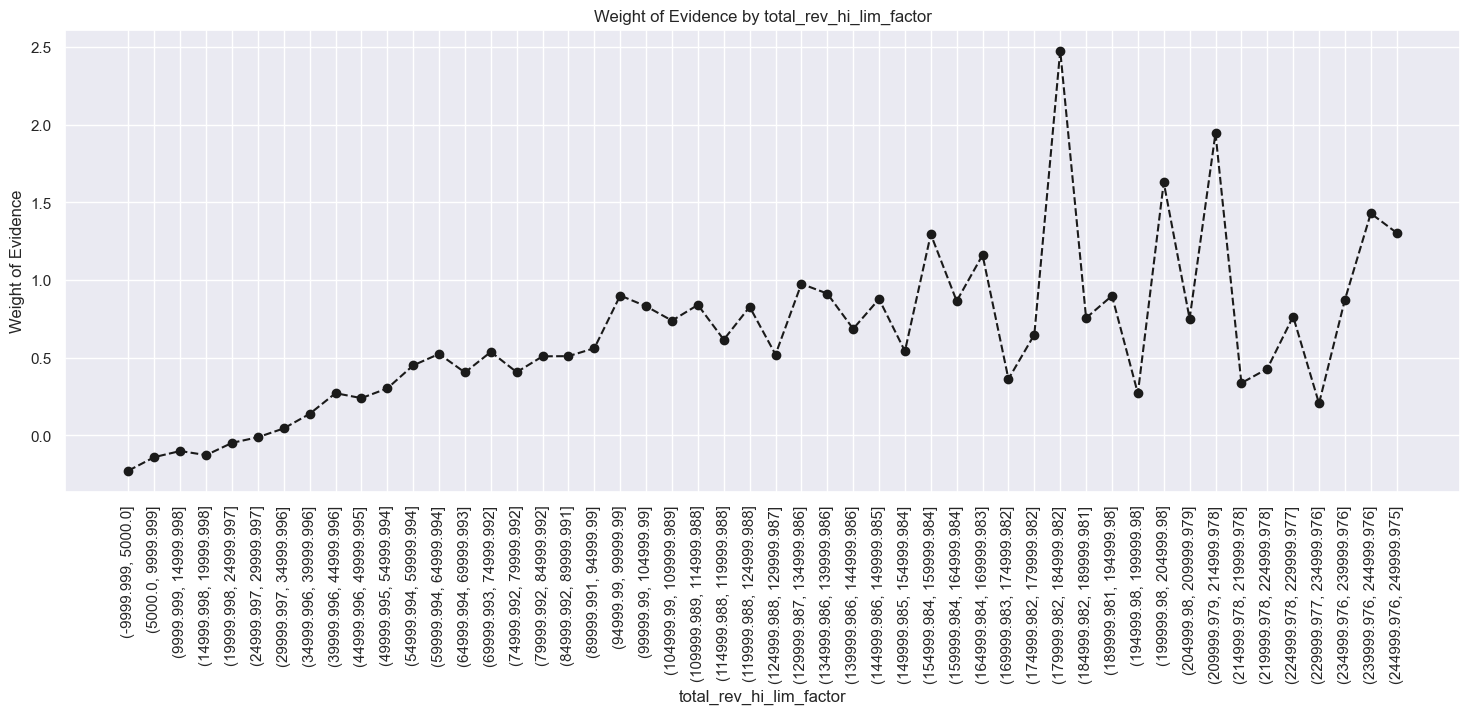

In [86]:
plot_by_woe(df_temp.iloc[: 50, : ], 90)
# We plot the weight of evidence values.

In [87]:
# Categories
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
df_inputs_prepr['total_rev_hi_lim:<=5K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] <= 5000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:5K-10K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 5000) & (df_inputs_prepr['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:10K-20K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 10000) & (df_inputs_prepr['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:20K-30K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 20000) & (df_inputs_prepr['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:30K-40K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 30000) & (df_inputs_prepr['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:40K-55K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 40000) & (df_inputs_prepr['total_rev_hi_lim'] <= 55000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:55K-95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 55000) & (df_inputs_prepr['total_rev_hi_lim'] <= 95000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:>95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 95000), 1, 0)

/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/429332966.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['total_rev_hi_lim:55K-95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 55000) & (df_inputs_prepr['total_rev_hi_lim'] <= 95000), 1, 0)
/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/429332966.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['total_rev_hi_lim:>95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 95000), 1, 0)


### 14. Variable : installment

In [88]:
df_inputs_prepr['installment'].describe()

count   373028
mean       432
std        244
min         16
25%        256
50%        380
75%        566
max       1410
Name: installment, dtype: float64

In [89]:
# installment
df_inputs_prepr['installment_factor'] = pd.cut(df_inputs_prepr['installment'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'installment_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/3261930107.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['installment_factor'] = pd.cut(df_inputs_prepr['installment'], 50)


,installment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(14.276, 43.556]",1812,1,0,1642,170,0,0,0,NaN,NaN,0
1,"(43.556, 71.443]",4841,1,0,4345,496,0,0,0,0,0,0
2,"(71.443, 99.329]",6824,1,0,6094,730,0,0,0,0,0,0
3,"(99.329, 127.216]",9138,1,0,8136,1002,0,0,-0,0,0,0
4,"(127.216, 155.102]",10040,1,0,9001,1039,0,0,0,0,0,0
5,"(155.102, 182.988]",16816,1,0,15037,1779,0,0,0,0,0,0
6,"(182.988, 210.875]",17216,1,0,15577,1639,0,0,0,0,0,0
7,"(210.875, 238.761]",15090,1,0,13587,1503,0,0,0,0,0,0
8,"(238.761, 266.648]",18842,1,0,16984,1858,0,0,0,0,0,0
9,"(266.648, 294.534]",20100,1,0,17911,2189,0,0,0,0,0,0


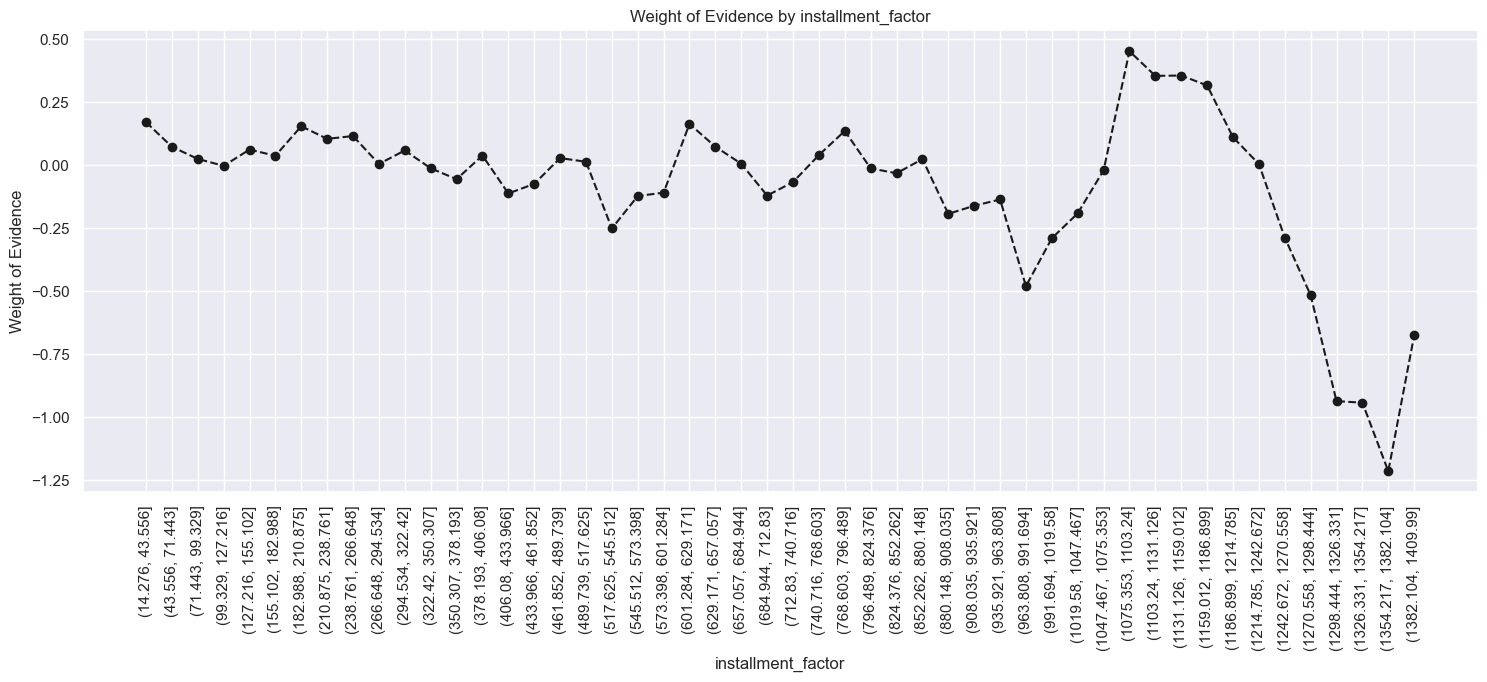

In [90]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

### 15. annual_inc

In [91]:
df_inputs_prepr['annual_inc'].describe()

count    373028
mean      73224
std       53689
min        1896
25%       45000
50%       62893
75%       88800
max     7141778
Name: annual_inc, dtype: float64

In [92]:
# annual_inc
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/1970114545.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 50)


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-5243.882, 144693.64]",351904,1,1,312690,39214,1,1,-0,NaN,NaN,inf
1,"(144693.64, 287491.28]",19004,1,0,17587,1417,0,0,0,0,0,inf
2,"(287491.28, 430288.92]",1525,1,0,1419,106,0,0,0,0,0,inf
3,"(430288.92, 573086.56]",332,1,0,312,20,0,0,1,0,0,inf
4,"(573086.56, 715884.2]",112,1,0,99,13,0,0,-0,0,1,inf
5,"(715884.2, 858681.84]",65,1,0,58,7,0,0,0,0,0,inf
6,"(858681.84, 1001479.48]",39,1,0,38,1,0,0,2,0,2,inf
7,"(1001479.48, 1144277.12]",10,1,0,10,0,0,0,inf,0,inf,inf
8,"(1144277.12, 1287074.76]",12,1,0,12,0,0,0,inf,0,NaN,inf
9,"(1287074.76, 1429872.4]",6,1,0,6,0,0,0,inf,0,NaN,inf


In [93]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 100)
# Here we do fine-classing: using the 'cut' method, we split the variable into 100 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-5243.882, 73294.82]",231445,1,1,202723,28722,1,1,-0,NaN,NaN,inf
1,"(73294.82, 144693.64]",120459,1,0,109967,10492,0,0,0,0,0,inf
2,"(144693.64, 216092.46]",15885,1,0,14695,1190,0,0,0,0,0,inf
3,"(216092.46, 287491.28]",3119,1,0,2892,227,0,0,0,0,0,inf
4,"(287491.28, 358890.1]",1117,1,0,1038,79,0,0,0,0,0,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(6784783.9, 6856182.72]",0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
96,"(6856182.72, 6927581.54]",0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
97,"(6927581.54, 6998980.36]",0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
98,"(6998980.36, 7070379.18]",0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


In [94]:
# Initial examination shows that there are too few individuals with large income and too many with small income.
# Hence, we are going to have one category for more than 150K, and we are going to apply our approach to determine
# the categories of everyone with 140k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc'] <= 140000, : ]
#loan_data_temp = loan_data_temp.reset_index(drop = True)
#df_inputs_prepr_temp

In [95]:
df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'annual_inc_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/2604529898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(1757.896, 4658.08]",15,1,0,12,3,0,0,-1,NaN,NaN,0
1,"(4658.08, 7420.16]",40,1,0,30,10,0,0,-1,0,0,0
2,"(7420.16, 10182.24]",287,1,0,251,36,0,0,-0,0,1,0
3,"(10182.24, 12944.32]",547,1,0,453,94,0,0,-1,0,0,0
4,"(12944.32, 15706.4]",1210,1,0,1005,205,0,0,-0,0,0,0
5,"(15706.4, 18468.48]",1522,1,0,1290,232,0,0,-0,0,0,0
6,"(18468.48, 21230.56]",2928,1,0,2505,423,0,0,-0,0,0,0
7,"(21230.56, 23992.64]",2495,1,0,2107,388,0,0,-0,0,0,0
8,"(23992.64, 26754.72]",7016,1,0,5954,1062,0,0,-0,0,0,0
9,"(26754.72, 29516.8]",5643,1,0,4838,805,0,0,-0,0,0,0


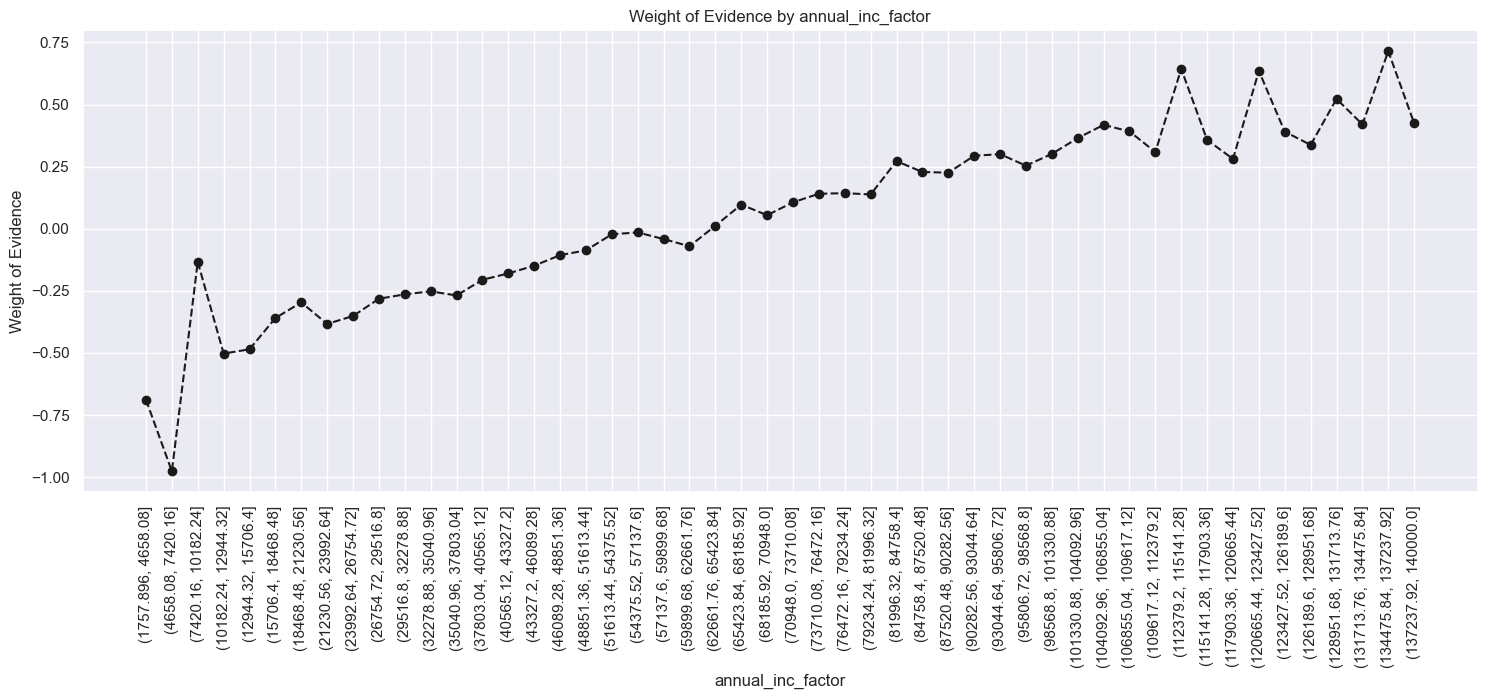

In [96]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [97]:
# WoE is monotonically decreasing with income, so we split income in 10 equal categories, each with width of 15k.
df_inputs_prepr['annual_inc:<20K'] = np.where((df_inputs_prepr['annual_inc'] <= 20000), 1, 0)
df_inputs_prepr['annual_inc:20K-30K'] = np.where((df_inputs_prepr['annual_inc'] > 20000) & (df_inputs_prepr['annual_inc'] <= 30000), 1, 0)
df_inputs_prepr['annual_inc:30K-40K'] = np.where((df_inputs_prepr['annual_inc'] > 30000) & (df_inputs_prepr['annual_inc'] <= 40000), 1, 0)
df_inputs_prepr['annual_inc:40K-50K'] = np.where((df_inputs_prepr['annual_inc'] > 40000) & (df_inputs_prepr['annual_inc'] <= 50000), 1, 0)
df_inputs_prepr['annual_inc:50K-60K'] = np.where((df_inputs_prepr['annual_inc'] > 50000) & (df_inputs_prepr['annual_inc'] <= 60000), 1, 0)
df_inputs_prepr['annual_inc:60K-70K'] = np.where((df_inputs_prepr['annual_inc'] > 60000) & (df_inputs_prepr['annual_inc'] <= 70000), 1, 0)
df_inputs_prepr['annual_inc:70K-80K'] = np.where((df_inputs_prepr['annual_inc'] > 70000) & (df_inputs_prepr['annual_inc'] <= 80000), 1, 0)
df_inputs_prepr['annual_inc:80K-90K'] = np.where((df_inputs_prepr['annual_inc'] > 80000) & (df_inputs_prepr['annual_inc'] <= 90000), 1, 0)
df_inputs_prepr['annual_inc:90K-100K'] = np.where((df_inputs_prepr['annual_inc'] > 90000) & (df_inputs_prepr['annual_inc'] <= 100000), 1, 0)
df_inputs_prepr['annual_inc:100K-120K'] = np.where((df_inputs_prepr['annual_inc'] > 100000) & (df_inputs_prepr['annual_inc'] <= 120000), 1, 0)
df_inputs_prepr['annual_inc:120K-140K'] = np.where((df_inputs_prepr['annual_inc'] > 120000) & (df_inputs_prepr['annual_inc'] <= 140000), 1, 0)
df_inputs_prepr['annual_inc:>140K'] = np.where((df_inputs_prepr['annual_inc'] > 140000), 1, 0)

/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/3226331627.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['annual_inc:<20K'] = np.where((df_inputs_prepr['annual_inc'] <= 20000), 1, 0)
/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/3226331627.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['annual_inc:20K-30K'] = np.where((df_inputs_prepr['annual_inc'] > 20000) & (df_inputs_prepr['annual_inc'] <= 30000), 1, 0)
/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/

### 16. Variable: mths_since_last_delinq

In [98]:
df_inputs_prepr['mths_since_last_delinq'].describe()

count   172843
mean        34
std         22
min          0
25%         16
50%         31
75%         49
max        188
Name: mths_since_last_delinq, dtype: float64

In [99]:
# mths_since_last_delinq
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/1373989647.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/1373989647.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)


,mths_since_last_delinq_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.188, 3.76]",5277,1,0,4599,678,0,0,-0,NaN,NaN,inf
1,"(3.76, 7.52]",11167,1,0,9912,1255,0,0,-0,0,0,inf
2,"(7.52, 11.28]",13306,1,0,11880,1426,0,0,0,0,0,inf
3,"(11.28, 15.04]",13216,1,0,11747,1469,0,0,-0,0,0,inf
4,"(15.04, 18.8]",9337,1,0,8356,981,0,0,0,0,0,inf
5,"(18.8, 22.56]",11641,1,0,10392,1249,0,0,0,0,0,inf
6,"(22.56, 26.32]",10887,1,0,9758,1129,0,0,0,0,0,inf
7,"(26.32, 30.08]",10560,1,0,9452,1108,0,0,0,0,0,inf
8,"(30.08, 33.84]",7576,1,0,6835,741,0,0,0,0,0,inf
9,"(33.84, 37.6]",9795,1,0,8790,1005,0,0,0,0,0,inf


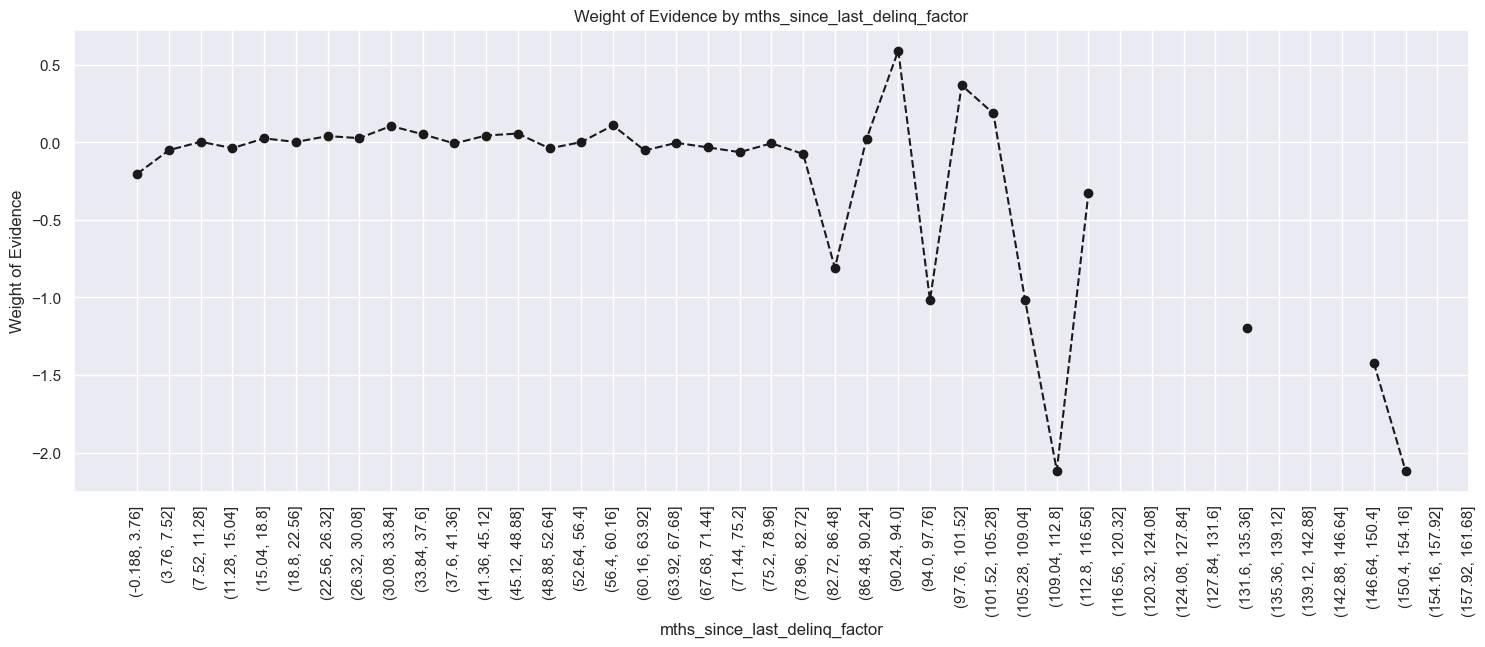

In [100]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [101]:
# Categories: Missing, 0-3, 4-30, 31-56, >=57
df_inputs_prepr['mths_since_last_delinq:Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_delinq:0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) & (df_inputs_prepr['mths_since_last_delinq'] <= 3), 1, 0)
df_inputs_prepr['mths_since_last_delinq:4-30'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 4) & (df_inputs_prepr['mths_since_last_delinq'] <= 30), 1, 0)
df_inputs_prepr['mths_since_last_delinq:31-56'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 31) & (df_inputs_prepr['mths_since_last_delinq'] <= 56), 1, 0)
df_inputs_prepr['mths_since_last_delinq:>=57'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 57), 1, 0)

/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/3878719826.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['mths_since_last_delinq:Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/3878719826.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['mths_since_last_delinq:0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) & (df_inputs_prepr['mths_since_last_delinq'] <= 3), 1

### 17. Variable: DTI

In [102]:
df_inputs_prepr['dti'].describe()


count   373028
mean        17
std          8
min          0
25%         11
50%         17
75%         23
max         40
Name: dti, dtype: float64

In [103]:
# dti
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 100)
# Here we do fine-classing: using the 'cut' method, we split the variable into 100 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'dti_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/3847891282.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 100)


,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.04, 0.4]",745,1,0,653,92,0,0,-0,NaN,NaN,0
1,"(0.4, 0.8]",808,1,0,743,65,0,0,0,0,0,0
2,"(0.8, 1.2]",922,1,0,827,95,0,0,0,0,0,0
3,"(1.2, 1.6]",1043,1,0,935,108,0,0,0,0,0,0
4,"(1.6, 2.0]",1172,1,0,1058,114,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(37.991, 38.39]",202,1,0,173,29,0,0,-0,0,1,0
96,"(38.39, 38.79]",193,1,0,170,23,0,0,-0,0,0,0
97,"(38.79, 39.19]",192,1,0,167,25,0,0,-0,0,0,0
98,"(39.19, 39.59]",183,1,0,168,15,0,0,0,0,1,0


In [104]:
# Similarly to income, initial examination shows that most values are lower than 200.
# Hence, we are going to have one category for more than 35, and we are going to apply our approach to determine
# the categories of everyone with 150k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['dti'] <= 35, : ]

In [105]:
df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'dti_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/337294594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)


,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.035, 0.7]",1366,1,0,1222,144,0,0,0,NaN,NaN,0
1,"(0.7, 1.4]",1664,1,0,1486,178,0,0,0,0,0,0
2,"(1.4, 2.1]",1986,1,0,1813,173,0,0,0,0,0,0
3,"(2.1, 2.8]",2594,1,0,2369,225,0,0,0,0,0,0
4,"(2.8, 3.5]",3135,1,0,2831,304,0,0,0,0,0,0
5,"(3.5, 4.2]",3844,1,0,3520,324,0,0,0,0,0,0
6,"(4.2, 4.9]",4595,1,0,4200,395,0,0,0,0,0,0
7,"(4.9, 5.6]",5312,1,0,4848,464,0,0,0,0,0,0
8,"(5.6, 6.3]",5927,1,0,5422,505,0,0,0,0,0,0
9,"(6.3, 7.0]",6482,1,0,5909,573,0,0,0,0,0,0


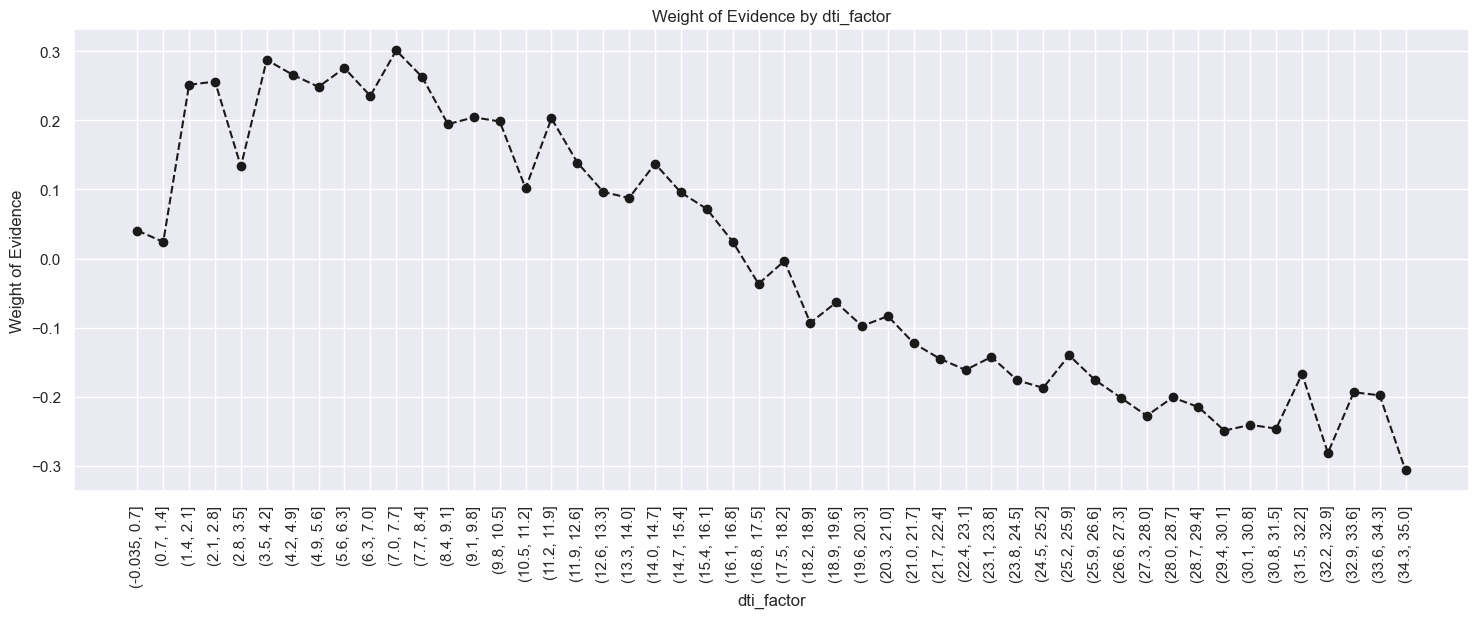

In [106]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [107]:
# Categories:
df_inputs_prepr['dti:<=1.4'] = np.where((df_inputs_prepr['dti'] <= 1.4), 1, 0)
df_inputs_prepr['dti:1.4-3.5'] = np.where((df_inputs_prepr['dti'] > 1.4) & (df_inputs_prepr['dti'] <= 3.5), 1, 0)
df_inputs_prepr['dti:3.5-7.7'] = np.where((df_inputs_prepr['dti'] > 3.5) & (df_inputs_prepr['dti'] <= 7.7), 1, 0)
df_inputs_prepr['dti:7.7-10.5'] = np.where((df_inputs_prepr['dti'] > 7.7) & (df_inputs_prepr['dti'] <= 10.5), 1, 0)
df_inputs_prepr['dti:10.5-16.1'] = np.where((df_inputs_prepr['dti'] > 10.5) & (df_inputs_prepr['dti'] <= 16.1), 1, 0)
df_inputs_prepr['dti:16.1-20.3'] = np.where((df_inputs_prepr['dti'] > 16.1) & (df_inputs_prepr['dti'] <= 20.3), 1, 0)
df_inputs_prepr['dti:20.3-21.7'] = np.where((df_inputs_prepr['dti'] > 20.3) & (df_inputs_prepr['dti'] <= 21.7), 1, 0)
df_inputs_prepr['dti:21.7-22.4'] = np.where((df_inputs_prepr['dti'] > 21.7) & (df_inputs_prepr['dti'] <= 22.4), 1, 0)
df_inputs_prepr['dti:22.4-35'] = np.where((df_inputs_prepr['dti'] > 22.4) & (df_inputs_prepr['dti'] <= 35), 1, 0)
df_inputs_prepr['dti:>35'] = np.where((df_inputs_prepr['dti'] > 35), 1, 0)

/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/284476014.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['dti:<=1.4'] = np.where((df_inputs_prepr['dti'] <= 1.4), 1, 0)
/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/284476014.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['dti:1.4-3.5'] = np.where((df_inputs_prepr['dti'] > 1.4) & (df_inputs_prepr['dti'] <= 3.5), 1, 0)
/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/284476014.py:4: Performan

### 18. Variable: mths_since_last_record

In [108]:
df_inputs_prepr['mths_since_last_record'].describe()

count   50067
mean       74
std        30
min         0
25%        53
50%        76
75%       102
max       121
Name: mths_since_last_record, dtype: float64

In [109]:
# mths_since_last_record
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_record'])]
#sum(loan_data_temp['mths_since_last_record'].isnull())
df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_record_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/3035104871.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/3035104871.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)


,mths_since_last_record_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.121, 2.42]",1086,1,0,830,256,0,0,-1,NaN,NaN,0
1,"(2.42, 4.84]",76,1,0,68,8,0,0,0,0,1,0
2,"(4.84, 7.26]",163,1,0,149,14,0,0,0,0,0,0
3,"(7.26, 9.68]",156,1,0,141,15,0,0,0,0,0,0
4,"(9.68, 12.1]",292,1,0,265,27,0,0,0,0,0,0
5,"(12.1, 14.52]",207,1,0,190,17,0,0,0,0,0,0
6,"(14.52, 16.94]",210,1,0,195,15,0,0,0,0,0,0
7,"(16.94, 19.36]",334,1,0,303,31,0,0,0,0,0,0
8,"(19.36, 21.78]",283,1,0,265,18,0,0,1,0,0,0
9,"(21.78, 24.2]",455,1,0,409,46,0,0,0,0,1,0


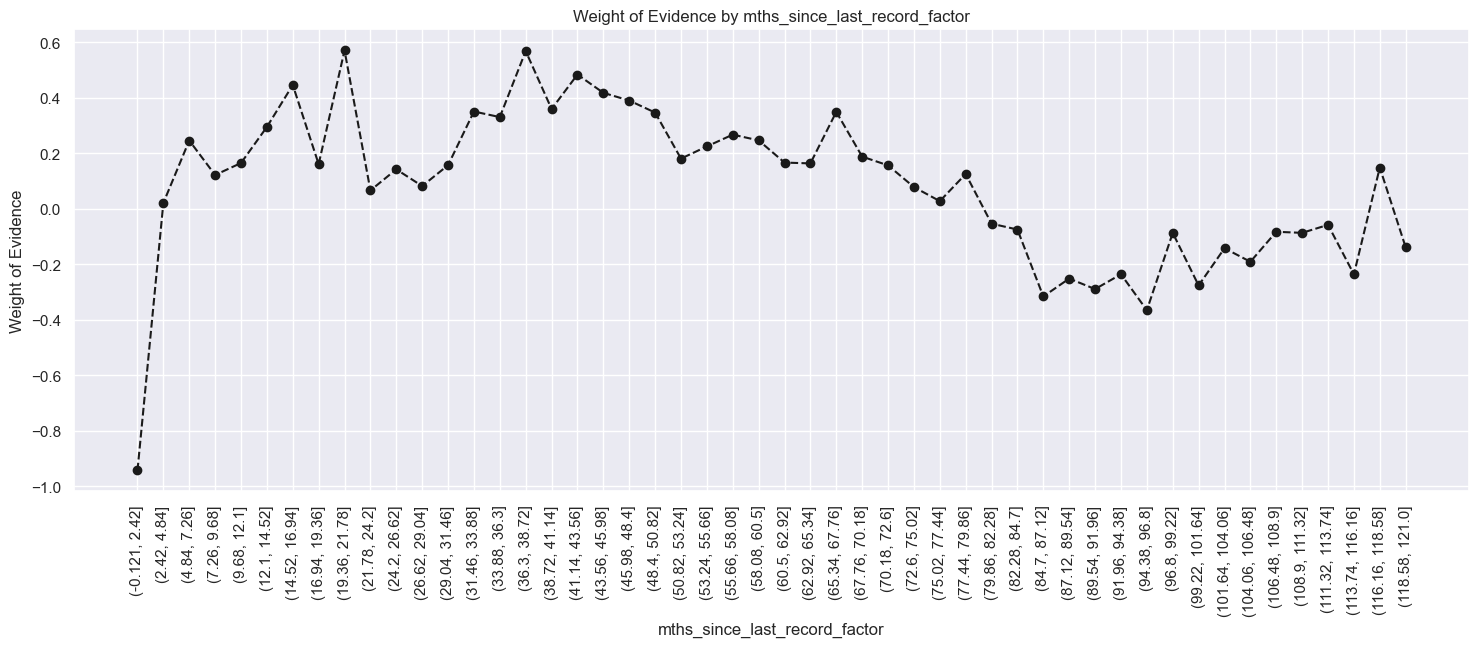

In [110]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [111]:
# Categories: 'Missing', '0-2', '3-20', '21-31', '32-80', '81-86', '>86'
df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_record:0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & (df_inputs_prepr['mths_since_last_record'] <= 2), 1, 0)
df_inputs_prepr['mths_since_last_record:3-20'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 3) & (df_inputs_prepr['mths_since_last_record'] <= 20), 1, 0)
df_inputs_prepr['mths_since_last_record:21-31'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 21) & (df_inputs_prepr['mths_since_last_record'] <= 31), 1, 0)
df_inputs_prepr['mths_since_last_record:32-80'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 32) & (df_inputs_prepr['mths_since_last_record'] <= 80), 1, 0)
df_inputs_prepr['mths_since_last_record:81-86'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 81) & (df_inputs_prepr['mths_since_last_record'] <= 86), 1, 0)
df_inputs_prepr['mths_since_last_record:>86'] = np.where((df_inputs_prepr['mths_since_last_record'] > 86), 1, 0)

/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/1059239224.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
/var/folders/jm/4cmln_kj5c3fzg5f9mkf28s40000gn/T/ipykernel_1857/1059239224.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['mths_since_last_record:0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & (df_inputs_prepr['mths_since_last_record'] <= 2), 1

# Saving Preprocessed Dataset for Training

In [112]:
loan_data_inputs_train = df_inputs_prepr

In [113]:
loan_data_targets_train = df_targets_prepr

In [114]:
loan_data_inputs_train.to_pickle('../loan_data_inputs_train.pkl')
loan_data_targets_train.to_pickle('../loan_data_targets_train.pkl')